In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

#import pingouin as pg
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

%matplotlib inline 

from platform import python_version
print(python_version())

3.8.5


In [2]:
ls

MSA Roll-Up.ipynb          crosswalk_after_2014.csv
Untitled.ipynb             crosswalk_before_2013.csv
cbsa_2009.xls              msa_census_2013.csv
cbsa_2013.xls              msa_census_2018.csv
codes.xlsx                 notes_03_21.docx


In [33]:
xls = pd.ExcelFile('codes.xlsx')

xls.sheet_names

['pre-2014', 'post-2014', 'all FIPS codes', 'Decoding EGEOLOC']

# do post-2014

In [34]:
df = pd.read_excel(xls, 'post-2014')
df=df[df.EGEOLOC != 1]
df['MSA'] = df['MSA'].astype(int)

df_xwalk = pd.read_excel('cbsa_2013.xls', header=2)
df_xwalk = df_xwalk.iloc[:-3, :].copy()
df_xwalk['CBSA Code'] = df_xwalk['CBSA Code'].astype(int)

In [35]:
#start with the ones that end with 0

df_temp = df[(df.MSA > 0) & (np.mod(df.MSA,10) == 0)].copy()
df_temp.shape

(417, 2)

In [36]:
df_state = pd.read_excel(xls, 'Decoding EGEOLOC')
df_temp = pd.merge(df_temp, df_state, on='EGEOLOC')
df_temp.shape

(417, 3)

In [37]:
df_temp = pd.merge(df_temp, df_xwalk, left_on = ['MSA', 'Label'], right_on = ['CBSA Code', 'State Name'])
df_temp.shape

(1055, 15)

In [38]:
#should be null 
df_temp[df_temp['Label'] != df_temp['State Name']][['Label', 'State Name']]

,Label,State Name


In [39]:
cols = ['MSA', 
        'EGEOLOC', 
        'State Name', 
        'FIPS State Code', 
        'FIPS County Code', 
        'County Name',
        'Metropolitan/Micropolitan Statistical Area', 
        'Central/Outlying County'
       ]

for col in ['FIPS State Code', 'FIPS County Code']:
    df_temp[col] = df_temp[col].astype(int)

df_temp['County Name'] = df_temp['County/County Equivalent']

df_temp = df_temp[cols].drop_duplicates()

In [40]:
df_ends_with_0 = df_temp.copy()

In [41]:
#Next do the the ones that end with 4

df_temp = df[(df.MSA > 0) & (np.mod(df.MSA,10) == 4)].copy()
df_temp.shape

(39, 2)

In [42]:
df_state = pd.read_excel(xls, 'Decoding EGEOLOC')
df_temp = pd.merge(df_temp, df_state, on='EGEOLOC')
df_temp.shape

(39, 3)

In [43]:
df_temp = pd.merge(df_temp, df_xwalk, left_on = ['MSA', 'Label'], right_on = ['Metro Division Code', 'State Name'])
df_temp.shape

(113, 15)

In [44]:
#should be null 
df_temp[df_temp['Label'] != df_temp['State Name']][['Label', 'State Name']]

,Label,State Name


In [45]:
cols = ['MSA', 
        'EGEOLOC', 
        'State Name', 
        'FIPS State Code', 
        'FIPS County Code', 
        'County Name',
        'Metropolitan/Micropolitan Statistical Area', 
        'Central/Outlying County'
       ]

for col in ['FIPS State Code', 'FIPS County Code']:
    df_temp[col] = df_temp[col].astype(int)

df_temp['County Name'] = df_temp['County/County Equivalent']

df_temp = df_temp[cols].drop_duplicates()

In [46]:
df_ends_with_4 = df_temp.copy()

In [47]:
df_ends_with_4

,MSA,EGEOLOC,State Name,FIPS State Code,FIPS County Code,County Name,Metropolitan/Micropolitan Statistical Area,Central/Outlying County
0,14454,6,Massachusetts,25,21,Norfolk County,Metropolitan Statistical Area,Central
1,14454,6,Massachusetts,25,23,Plymouth County,Metropolitan Statistical Area,Central
2,14454,6,Massachusetts,25,25,Suffolk County,Metropolitan Statistical Area,Central
3,15764,6,Massachusetts,25,9,Essex County,Metropolitan Statistical Area,Central
4,15764,6,Massachusetts,25,17,Middlesex County,Metropolitan Statistical Area,Central
...,...,...,...,...,...,...,...,...
108,41884,62,California,6,81,San Mateo County,Metropolitan Statistical Area,Central
109,42034,62,California,6,41,Marin County,Metropolitan Statistical Area,Central
110,42644,65,Washington,53,33,King County,Metropolitan Statistical Area,Central
111,42644,65,Washington,53,61,Snohomish County,Metropolitan Statistical Area,Central


In [48]:
#and finally, do all the ones that don't get matched anywhere

In [49]:
df_temp = pd.concat([df_ends_with_4, df_ends_with_0])
df_state_xwalk = df_temp[['EGEOLOC', 'FIPS State Code']].drop_duplicates()

df = pd.read_excel(xls, 'all FIPS codes')
df.shape

(3143, 8)

In [50]:
df_temp = pd.merge(df, df_temp, how='left', left_on = ['County FIPS Code', 'State FIPS Code'], right_on = ['FIPS County Code', 'FIPS State Code'])

In [51]:
df_msa_0 = pd.merge(df_temp[(df_temp.MSA.isna())][['County', 'County FIPS Code', 'State', 'State FIPS Code']],
                    df_state_xwalk, 
                    left_on = 'State FIPS Code',
                    right_on = 'FIPS State Code')
df_msa_0

,County,County FIPS Code,State,State FIPS Code,EGEOLOC,FIPS State Code
0,Barbour,5,Alabama,1,41,1
1,Bullock,11,Alabama,1,41,1
2,Butler,13,Alabama,1,41,1
3,Chambers,17,Alabama,1,41,1
4,Cherokee,19,Alabama,1,41,1
...,...,...,...,...,...,...
1970,Sweetwater,37,Wyoming,56,59,56
1971,Teton,39,Wyoming,56,59,56
1972,Uinta,41,Wyoming,56,59,56
1973,Washakie,43,Wyoming,56,59,56


In [52]:
df_msa_0['MSA'] = 0
df_msa_0['State Name'] = df_msa_0['State']
df_msa_0['County Name'] = df_msa_0['County']
df_msa_0['FIPS County Code'] = df_msa_0['County FIPS Code']
df_msa_0['Metropolitan/Micropolitan Statistical Area'] = 'Rural'
df_msa_0['Central/Outlying County'] = 'Rural'

df_msa_0 = df_msa_0[cols].copy()

In [53]:
df = pd.concat([df_ends_with_4, df_ends_with_0, df_msa_0]).reset_index()[cols]
df.to_csv('crosswalk_after_2014.csv')

# now do pre-2014

In [147]:
df = pd.read_excel(xls, 'pre-2014')
df=df[(df.EGEOLOC != 1) & (~df.MSA.isna())]
df['MSA'] = df['MSA'].astype(int)

df_xwalk = pd.read_excel('cbsa_2009.xls', header=3)
df_xwalk = df_xwalk.iloc[:-4, :].copy()
df_xwalk['CBSA Code'] = df_xwalk['CBSA Code'].astype(int)

In [148]:
#start with the ones that end with 0

df_temp = df[(df.MSA > 0) & (np.mod(df.MSA,10) == 0)].copy()
df_temp.shape

(403, 2)

In [149]:
df_state = pd.read_excel(xls, 'Decoding EGEOLOC')
df_temp = pd.merge(df_temp, df_state, on='EGEOLOC')
df_temp.shape

(403, 3)

In [150]:
df_temp = pd.merge(df_temp, df_xwalk, left_on = ['MSA', 'Label'], right_on = ['CBSA Code', 'State'])
df_temp.shape

(992, 15)

In [151]:
#should be null 
df_temp[df_temp['Label'] != df_temp['State']][['Label', 'State']]

,Label,State


In [152]:
cols = ['MSA', 
        'EGEOLOC', 
        'State Name', 
        'FIPS State Code', 
        'FIPS County Code', 
        'County Name',
        'Metropolitan/Micropolitan Statistical Area', 
        'Central/Outlying County'
       ]

df_temp['State Name'] = df_temp['State']
df_temp['FIPS County Code'] = np.mod(df_temp.FIPS,1000).astype(int)
df_temp['FIPS State Code'] = np.floor(df_temp.FIPS/1000).astype(int)

df_temp['County Name'] = df_temp['Component Name']
df_temp['Metropolitan/Micropolitan Statistical Area'] = df_temp['Level of CBSA']
df_temp['Central/Outlying County'] = df_temp['County Status']

df_temp = df_temp[cols].drop_duplicates()

In [153]:
df_ends_with_0 = df_temp.copy()

In [154]:
#Next do the the ones that end with 4

df_temp = df[(df.MSA > 0) & (np.mod(df.MSA,10) == 4)].copy()
df_temp.shape

(37, 2)

In [155]:
df_state = pd.read_excel(xls, 'Decoding EGEOLOC')
df_temp = pd.merge(df_temp, df_state, on='EGEOLOC')
df_temp.shape

(37, 3)

In [156]:
df_temp = pd.merge(df_temp, df_xwalk, left_on = ['MSA', 'Label'], right_on = ['Metro Division Code', 'State'])
df_temp.shape

(108, 15)

In [157]:
#should be null 
df_temp[df_temp['Label'] != df_temp['State']][['Label', 'State']]

,Label,State


In [158]:
cols = ['MSA', 
        'EGEOLOC', 
        'State Name', 
        'FIPS State Code', 
        'FIPS County Code', 
        'County Name',
        'Metropolitan/Micropolitan Statistical Area', 
        'Central/Outlying County'
       ]

df_temp['State Name'] = df_temp['State']
df_temp['FIPS County Code'] = np.mod(df_temp.FIPS,1000).astype(int)
df_temp['FIPS State Code'] = np.floor(df_temp.FIPS/1000).astype(int)

df_temp['County Name'] = df_temp['Component Name']
df_temp['Metropolitan/Micropolitan Statistical Area'] = df_temp['Level of CBSA']
df_temp['Central/Outlying County'] = df_temp['County Status']

df_temp = df_temp[cols].drop_duplicates()

In [159]:
df_ends_with_4 = df_temp.copy()

In [160]:
df_ends_with_4

,MSA,EGEOLOC,State Name,FIPS State Code,FIPS County Code,County Name,Metropolitan/Micropolitan Statistical Area,Central/Outlying County
0,14484,6,Massachusetts,25,21,Norfolk County,Metropolitan Statistical Area,Central
1,14484,6,Massachusetts,25,23,Plymouth County,Metropolitan Statistical Area,Central
2,14484,6,Massachusetts,25,25,Suffolk County,Metropolitan Statistical Area,Central
3,15764,6,Massachusetts,25,17,Middlesex County,Metropolitan Statistical Area,Central
4,37764,6,Massachusetts,25,9,Essex County,Metropolitan Statistical Area,Central
...,...,...,...,...,...,...,...,...
103,41884,62,California,6,81,San Mateo County,Metropolitan Statistical Area,Central
104,42044,62,California,6,59,Orange County,Metropolitan Statistical Area,Central
105,42644,65,Washington,53,33,King County,Metropolitan Statistical Area,Central
106,42644,65,Washington,53,61,Snohomish County,Metropolitan Statistical Area,Central


In [161]:
#and finally, do all the ones that don't get matched anywhere

In [162]:
df_temp = pd.concat([df_ends_with_4, df_ends_with_0])
df_state_xwalk = df_temp[['EGEOLOC', 'FIPS State Code']].drop_duplicates()

df = pd.read_excel(xls, 'all FIPS codes')
df.shape

(3143, 8)

In [163]:
df_temp = pd.merge(df, df_temp, how='left', left_on = ['County FIPS Code', 'State FIPS Code'], right_on = ['FIPS County Code', 'FIPS State Code'])

In [164]:
df_msa_0 = pd.merge(df_temp[(df_temp.MSA.isna())][['County', 'County FIPS Code', 'State', 'State FIPS Code']],
                    df_state_xwalk, 
                    left_on = 'State FIPS Code',
                    right_on = 'FIPS State Code')
df_msa_0

,County,County FIPS Code,State,State FIPS Code,EGEOLOC,FIPS State Code
0,Baldwin,3,Alabama,1,41,1
1,Barbour,5,Alabama,1,41,1
2,Bullock,11,Alabama,1,41,1
3,Butler,13,Alabama,1,41,1
4,Chambers,17,Alabama,1,41,1
...,...,...,...,...,...,...
2038,Sweetwater,37,Wyoming,56,59,56
2039,Teton,39,Wyoming,56,59,56
2040,Uinta,41,Wyoming,56,59,56
2041,Washakie,43,Wyoming,56,59,56


In [165]:
df_msa_0['MSA'] = 0
df_msa_0['State Name'] = df_msa_0['State']
df_msa_0['County Name'] = df_msa_0['County']
df_msa_0['FIPS County Code'] = df_msa_0['County FIPS Code']
df_msa_0['Metropolitan/Micropolitan Statistical Area'] = 'Rural'
df_msa_0['Central/Outlying County'] = 'Rural'

df_msa_0 = df_msa_0[cols].copy()

In [166]:
df = pd.concat([df_ends_with_4, df_ends_with_0, df_msa_0]).reset_index()[cols]
df.to_csv('crosswalk_before_2013.csv')

# do 2013 census data

In [99]:
import censusdata

census_datapoints = {
 'B01003_001E': 'Total Pop',
 'B03002_003E': 'White Pop',
 'B03002_004E': 'Black Pop',
 'B03002_012E': 'Hispanic Pop',
 'B03002_006E': 'Asian Pop',
        
 'B01001_001E': 'Total Population',
 'B01001_002E': 'Male',
 
 'B19001_001E': 'Tot HHs',
 'B19001_002E': 'HH < 10K',
 'B19001_003E': '10k < HH < 15K',
 'B19001_004E': '15k < HH < 20K',
 'B19001_005E': '20k < HH < 25K',
 'B19001_006E': '25k < HH < 30K',
 'B19001_007E': '30k < HH < 35K',
 'B19001_008E': '35k < HH < 40K',
 'B19001_009E': '40k < HH < 45K',
 'B19001_010E': '45k < HH < 50K',
 'B19001_011E': '50k < HH < 60K',
 'B19001_012E': '60k < HH < 75K',
 'B19001_013E': '75k < HH < 100K',
 'B19001_014E': '100k < HH < 125K',
 'B19001_015E': '125k < HH < 150K',
 'B19001_016E': '150k < HH < 200K',
 'B19001_017E': '200k < HH',
 
 'B23025_005E': 'Unemployed Labor Force',
 'B23025_003E': 'Labor Force',
 
 'B06009_001E': 'Education Known',
 'B06009_002E': 'Less than HS',
 'B06009_003E': 'HS',
 'B06009_004E': 'Some College',
 'B06009_005E': 'College',
 'B06009_006E': 'Graduate',
 
 'B25003_001E': 'Houses',
 'B25003_002E': 'Owner-occupied houses',
 
 'B25109_001E': 'Median house price',

 'B27011_001E': 'Insurance Denominator',   
 'B27011_007E': 'Uninsured Numerator 1',
 'B27011_012E': 'Uninsured Numerator 2',
 'B27011_017E': 'Uninsured Numerator 3',
    
# 'B01001_001E': 'Total Population',
 'B01001_003E': 'Under 18 1',
 'B01001_004E': 'Under 18 2',
 'B01001_005E': 'Under 18 3', 
 'B01001_006E': 'Under 18 4',
 'B01001_027E': 'Under 18 5',
 'B01001_028E': 'Under 18 6', 
 'B01001_029E': 'Under 18 7',
 'B01001_030E': 'Under 18 8',
    
 'B01001_007E': '18 - 40 1',
 'B01001_008E': '18 - 40 2',    
 'B01001_009E': '18 - 40 3',  
 'B01001_010E': '18 - 40 4',
 'B01001_011E': '18 - 40 5',    
 'B01001_012E': '18 - 40 6',    
 'B01001_013E': '18 - 40 7',  
 'B01001_031E': '18 - 40 8',
 'B01001_032E': '18 - 40 9',    
 'B01001_033E': '18 - 40 10',  
 'B01001_034E': '18 - 40 11',
 'B01001_035E': '18 - 40 12',    
 'B01001_036E': '18 - 40 13',    
 'B01001_037E': '18 - 40 14',
    
 'B01001_014E': '40 - 60 1',
 'B01001_015E': '40 - 60 2',    
 'B01001_016E': '40 - 60 3',  
 'B01001_017E': '40 - 60 4',
 'B01001_038E': '40 - 60 5',    
 'B01001_039E': '40 - 60 6',    
 'B01001_040E': '40 - 60 7',  
 'B01001_041E': '40 - 60 8',
    
 'B01001_018E': '60 - 80 1',
 'B01001_019E': '60 - 80 2',    
 'B01001_020E': '60 - 80 3',  
 'B01001_021E': '60 - 80 4',
 'B01001_022E': '60 - 80 5',    
 'B01001_023E': '60 - 80 6', 
 'B01001_042E': '60 - 80 7',
 'B01001_043E': '60 - 80 8',    
 'B01001_044E': '60 - 80 9',  
 'B01001_045E': '60 - 80 10',
 'B01001_046E': '60 - 80 11',    
 'B01001_047E': '60 - 80 12'
 }
        

state_codes = [      '01', '02',       '04', '05', '06',       '08', '09',
               '10', '11', '12', '13',       '15', '16', '17', '18', '19', 
               '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
               '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
               '40', '41', '42',       '44', '45', '46', '47', '48', '49',
               '50', '51',       '53', '54', '55', '56'
              ]
    
state_data = []
for state in state_codes:
    state_data.append(censusdata.download('acs5', 2013, censusdata.censusgeo([('state', state) , 
                                        ('county', '*')]), 
                                         list(census_datapoints.keys())))
df = pd.concat(state_data)
df['Census ID'] = df.index


In [100]:
df['County Code'] = df['Census ID'].apply(lambda x: str(x).split('county:')[-1][:3])
df['State Code'] = df['Census ID'].apply(lambda x: str(x).split('state:')[-1][:2])
df['County'] = df['Census ID'].apply(lambda x: str(x).split(', ')[0][:-7])
df['State'] = df['Census ID'].apply(lambda x: str(x).split(', ')[1].split(':')[0])

In [101]:
state_data = []
for state in state_codes:
    gazeteer_url = 'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2012_Gazetteer/2012_gaz_tracts_' + state + '.txt'
    census_tract_geometry = pd.read_table(gazeteer_url)
    state_data.append(census_tract_geometry)
    
df_geo = pd.concat(state_data)
df_geo.rename(columns={'ALAND_SQMI':'Square Miles'}, inplace=True)

In [102]:
df_geo['county code'] = np.mod(np.floor(df_geo['GEOID']/1000000),1000).astype(int)
df_geo['state code'] = np.floor(np.floor(df_geo['GEOID']/1000000)/1000).astype(int)

df_geo = pd.DataFrame(df_geo.groupby(['state code', 'county code'])['Square Miles'].sum()).reset_index()

In [103]:
df.shape

(3143, 86)

In [104]:
df['state code'] = df['State Code'].astype(int)
df['county code'] = df['County Code'].astype(int)
df=pd.merge(df, df_geo, on=['state code', 'county code'])

In [105]:
df.shape

(3143, 89)

In [106]:
# clean up

df = df.rename(columns=census_datapoints)

df['frac_female'] = 1 - df['Male'] / df['Total Population']

df['frac_white'] = df['White Pop'] / df['Total Pop']
df['frac_black'] = df['Black Pop'] / df['Total Pop']
df['frac_hispanic'] = df['Hispanic Pop'] / df['Total Pop']
df['frac_asian'] = df['Asian Pop'] / df['Total Pop']
df['frac_other'] = 1 - df.frac_white - df.frac_black - df.frac_hispanic - df.frac_asian

df['frac_under_18'] = (df['Under 18 1'] + df['Under 18 2'] + df['Under 18 3'] + df['Under 18 4'] + df['Under 18 5'] + df['Under 18 6'] + df['Under 18 7'] + df['Under 18 8']) / df['Total Population']
df['frac_18_to_40'] = (df['18 - 40 1'] + df['18 - 40 2'] + df['18 - 40 3'] + df['18 - 40 4'] + df['18 - 40 5'] + df['18 - 40 6'] + df['18 - 40 7'] + df['18 - 40 8'] + df['18 - 40 9'] + df['18 - 40 10'] + df['18 - 40 11'] + df['18 - 40 12'] + df['18 - 40 13'] + df['18 - 40 14']) / df['Total Population']
df['frac_40_to_60'] = (df['40 - 60 1'] + df['40 - 60 2'] + df['40 - 60 3'] + df['40 - 60 4'] + df['40 - 60 5'] + df['40 - 60 6'] + df['40 - 60 7'] + df['40 - 60 8']) / df['Total Population']
df['frac_60_to_80'] = (df['60 - 80 1'] + df['60 - 80 2'] + df['60 - 80 3'] + df['60 - 80 4'] + df['60 - 80 5'] + df['60 - 80 6'] + df['60 - 80 7'] + df['60 - 80 8'] + df['60 - 80 9'] + df['60 - 80 10'] + df['60 - 80 11'] + df['60 - 80 12']) / df['Total Population']
df['frac_80_plus'] = 1 - df.frac_under_18 - df.frac_18_to_40 - df.frac_40_to_60 - df.frac_60_to_80

df['frac_lt_15k'] = (df['HH < 10K'] + df['10k < HH < 15K']) / df['Tot HHs']
df['frac_15k_to_30k'] = (df['15k < HH < 20K'] + df['20k < HH < 25K'] + df['25k < HH < 30K']) / df['Tot HHs']
df['frac_30k_to_45k'] = (df['30k < HH < 35K'] + df['35k < HH < 40K'] + df['40k < HH < 45K']) / df['Tot HHs']
df['frac_45k_to_60k'] = (df['45k < HH < 50K'] + df['50k < HH < 60K']) / df['Tot HHs']
df['frac_60k_to_100k'] = (df['60k < HH < 75K'] + df['75k < HH < 100K']) / df['Tot HHs']
df['frac_100k_to_125k'] = (df['100k < HH < 125K'] ) / df['Tot HHs']
df['frac_125k_to_200k'] = (df['125k < HH < 150K'] + df['150k < HH < 200K']) / df['Tot HHs']
df['frac_gt_200k'] = (df['200k < HH']) / df['Tot HHs']

df['frac_unemployed'] = df['Unemployed Labor Force'] / df['Labor Force']
df['frac_no_health_insurance'] = (df['Uninsured Numerator 1'] + df['Uninsured Numerator 2'] + df['Uninsured Numerator 3'])/df['Insurance Denominator']

df['frac_lt_hs'] = df['Less than HS'] / df['Education Known']
df['frac_hs'] = df['HS'] / df['Education Known']
df['frac_some_college'] = df['Some College'] / df['Education Known']
df['frac_college'] = df['College'] / df['Education Known']
df['frac_graduate'] = df['Graduate'] / df['Education Known']

df['frac_houses_owner_occupied'] = df['Owner-occupied houses'] / df['Houses']

df['pop_density'] = df['Total Pop'] / df['Square Miles']

df['median_house_price'] = df['Median house price']

df = df[['County Code', 'County', 'State Code', 'State', 'Square Miles',
     'Total Pop', 'pop_density','frac_female', 
     'frac_white', 'frac_black', 'frac_hispanic', 'frac_asian', 'frac_other',
     'frac_under_18', 'frac_18_to_40', 'frac_40_to_60', 'frac_60_to_80', 'frac_80_plus',
     'frac_lt_15k', 'frac_15k_to_30k', 'frac_30k_to_45k', 'frac_45k_to_60k',
           'frac_60k_to_100k', 'frac_100k_to_125k', 'frac_125k_to_200k', 'frac_gt_200k', 
     'frac_unemployed',  'frac_no_health_insurance',
     'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college', 'frac_graduate',
     'frac_houses_owner_occupied', 
     'median_house_price']]

df.loc[df.median_house_price < 0, 'median_house_price'] = df.loc[df.median_house_price > 0, 'median_house_price'].min()

In [107]:
df

,County Code,County,State Code,State,Square Miles,Total Pop,pop_density,frac_female,frac_white,frac_black,...,frac_gt_200k,frac_unemployed,frac_no_health_insurance,frac_lt_hs,frac_hs,frac_some_college,frac_college,frac_graduate,frac_houses_owner_occupied,median_house_price
0,037,Coosa,01,Alabama,650.926,11198,17.203184,0.493660,0.657975,0.305769,...,0.000222,0.177111,0.064675,0.249631,0.426745,0.225664,0.053958,0.044002,0.830004,75100
1,045,Dale,01,Alabama,561.151,50102,89.284346,0.507165,0.704782,0.189513,...,0.015146,0.104021,0.082246,0.158602,0.307574,0.364114,0.113050,0.056661,0.611269,99400
2,065,Hale,01,Alabama,643.943,15594,24.216429,0.525266,0.397717,0.590291,...,0.009717,0.162013,0.073978,0.226458,0.411647,0.234274,0.089687,0.037934,0.779863,79900
3,055,Etowah,01,Alabama,535.333,104260,194.757282,0.516689,0.790130,0.152005,...,0.012532,0.117597,0.061463,0.182240,0.327168,0.343033,0.095681,0.051877,0.724147,100000
4,049,DeKalb,01,Alabama,777.095,71076,91.463721,0.508076,0.813200,0.016489,...,0.011515,0.113678,0.055845,0.294025,0.349583,0.249298,0.064431,0.042663,0.763231,93400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,035,Sublette,56,Wyoming,4886.518,10178,2.082874,0.455492,0.859206,0.000098,...,0.038549,0.049134,0.071522,0.043782,0.291786,0.431546,0.158871,0.074016,0.744432,282800
3139,045,Weston,56,Wyoming,2398.095,7153,2.982784,0.476024,0.942821,0.002097,...,0.017815,0.040732,0.057116,0.098482,0.355573,0.373951,0.123452,0.048542,0.761008,136000
3140,005,Campbell,56,Wyoming,4802.684,46901,9.765581,0.477538,0.885418,0.007079,...,0.044073,0.040700,0.062474,0.084775,0.372273,0.355345,0.141098,0.046508,0.748889,201900
3141,025,Natrona,56,Wyoming,5340.512,77343,14.482319,0.496089,0.881579,0.008171,...,0.040204,0.058072,0.082423,0.081720,0.285681,0.409727,0.152975,0.069896,0.696908,178300


In [108]:
ls

Untitled.ipynb             crosswalk_before_2013.csv
cbsa_2009.xls              msa_census_2013.csv
cbsa_2013.xls              msa_census_2018.csv
codes.xlsx                 notes_03_21.docx
crosswalk_after_2014.csv


In [109]:
df_crosswalk = pd.read_csv('crosswalk_before_2013.csv')

In [110]:
df_crosswalk.groupby(['MSA', 'EGEOLOC']).size().describe()

count    484.000000
mean       6.493802
std       15.803594
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max      177.000000
dtype: float64

In [111]:
df['FIPS County Code'] = df['County Code'].astype(int)
df['FIPS State Code'] = df['State Code'].astype(int)

df_temp = pd.merge(df, df_crosswalk, on = ['FIPS State Code', 'FIPS County Code'])

In [112]:
df_state = df_crosswalk[['EGEOLOC', 'State Name']].drop_duplicates()

In [113]:
df_msa = pd.merge(df_msa, df_state, on='EGEOLOC')

In [114]:
sum_metrics = ['Total Pop', 'Square Miles']
average_metrics = [ 'frac_female',
     'frac_white', 'frac_black', 'frac_hispanic', 'frac_asian', 'frac_other',
    'frac_under_18', 'frac_18_to_40', 'frac_40_to_60', 'frac_60_to_80', 'frac_80_plus',
     'frac_lt_15k', 'frac_15k_to_30k', 'frac_30k_to_45k', 'frac_45k_to_60k',
           'frac_60k_to_100k', 'frac_100k_to_125k', 'frac_125k_to_200k', 'frac_gt_200k', 
     'frac_unemployed', 'frac_no_health_insurance',
     'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college', 'frac_graduate',
     'frac_houses_owner_occupied', 
     'median_house_price', 
     #'food_insecurity', 'pct_snap', 'lila_tracts', 
     #'Ozone', 'PM2.5', 'Diesel PM', 'Drinking Water', 'Pesticides', 'Tox. Release', 'Traffic'
]

def rollup_sum(group, column):
    x = group[column]
    return (x).sum()

def rollup_avg(group, column, weight):
    x = group[column]
    w = group[weight]
    return (x * w).sum() /  w.sum()

df_msa = df_temp[['MSA', 'EGEOLOC']].drop_duplicates().reset_index()[['MSA', 'EGEOLOC']]

for column in sum_metrics:
    df_msa = pd.merge(df_msa, pd.DataFrame(df_temp.groupby(['MSA', 'EGEOLOC']).apply(rollup_sum, column), 
                               columns = [column]), on=['MSA', 'EGEOLOC'])
    
for column in average_metrics:
    df_msa = pd.merge(df_msa, pd.DataFrame(df_temp.groupby(['MSA', 'EGEOLOC']).apply(rollup_avg, column, 'Total Pop'), 
                               columns = [column]), on=['MSA', 'EGEOLOC'])

df_msa['pop_density'] = df_msa['Total Pop'] / df_msa['Square Miles']

In [115]:
df_state = df_crosswalk[['EGEOLOC', 'State Name']].drop_duplicates()

df_msa = pd.merge(df_msa, df_state, on='EGEOLOC')

In [116]:
df_msa

,MSA,EGEOLOC,Total Pop,Square Miles,frac_female,frac_white,frac_black,frac_hispanic,frac_asian,frac_other,...,frac_no_health_insurance,frac_lt_hs,frac_hs,frac_some_college,frac_college,frac_graduate,frac_houses_owner_occupied,median_house_price,pop_density,State Name
0,0,41,1363992,30813.338,0.511341,0.712014,0.219031,0.043102,0.004987,0.020866,...,0.070391,0.212913,0.346663,0.284237,0.099669,0.056518,0.718691,101833.232160,44.266285,Alabama
1,46220,41,221352,2612.826,0.517533,0.606645,0.341429,0.028154,0.012238,0.011534,...,0.067301,0.144371,0.320177,0.281145,0.152735,0.101573,0.657081,144875.951426,84.717467,Alabama
2,23460,41,104260,535.333,0.516689,0.790130,0.152005,0.034567,0.006541,0.016756,...,0.061463,0.182240,0.327168,0.343033,0.095681,0.051877,0.724147,100000.000000,194.757282,Alabama
3,33660,41,413188,1229.384,0.520233,0.587682,0.347108,0.024737,0.018890,0.021583,...,0.072576,0.160631,0.329747,0.302603,0.136552,0.070467,0.665938,124300.000000,336.093523,Alabama
4,13820,41,1132182,5279.574,0.517985,0.647694,0.283384,0.042877,0.012905,0.013140,...,0.072846,0.141472,0.280225,0.301881,0.175602,0.100820,0.705480,142335.752644,214.445711,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,20260,20,43994,1304.135,0.501182,0.923580,0.013252,0.012070,0.009820,0.041278,...,0.121226,0.073122,0.323830,0.385659,0.148416,0.068973,0.678498,130600.000000,33.734238,Wisconsin
480,36780,20,167860,434.490,0.497867,0.904122,0.016395,0.035750,0.022977,0.020755,...,0.094266,0.089730,0.348294,0.307470,0.178841,0.075665,0.663252,141300.000000,386.338005,Wisconsin
481,0,59,399718,89067.339,0.485617,0.857980,0.004886,0.085680,0.007788,0.043666,...,0.075777,0.077572,0.307219,0.363254,0.168734,0.083221,0.707760,212916.675756,4.487818,Wyoming
482,16940,59,93073,2685.921,0.498877,0.800662,0.026592,0.134529,0.010766,0.027452,...,0.089603,0.067432,0.273891,0.407356,0.158848,0.092473,0.681679,181700.000000,34.652173,Wyoming


In [117]:
#check a bunch of those distributions

(0.0, 10388155.05)

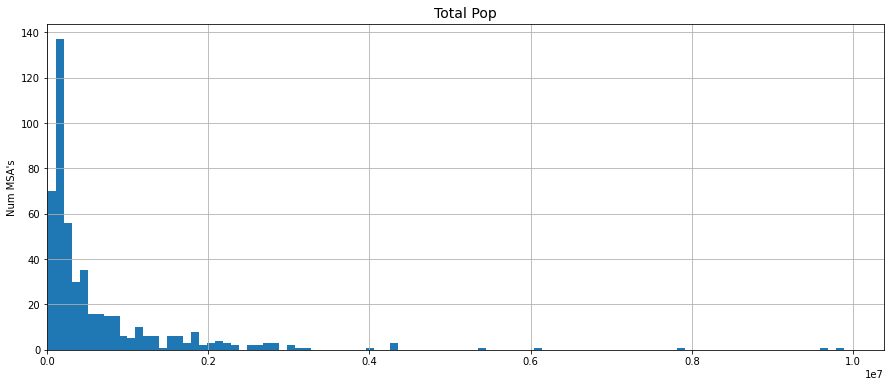

In [118]:
plt.figure(figsize=(15,6))

df_msa['Total Pop'].hist(bins=100)
plt.title('Total Pop', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,df_msa['Total Pop'].max()*1.05])

In [119]:
df_msa['Total Pop'].describe()

count    4.840000e+02
mean     6.436706e+05
std      1.044106e+06
min      7.905000e+03
25%      1.367332e+05
50%      2.573935e+05
75%      7.044945e+05
max      9.893481e+06
Name: Total Pop, dtype: float64

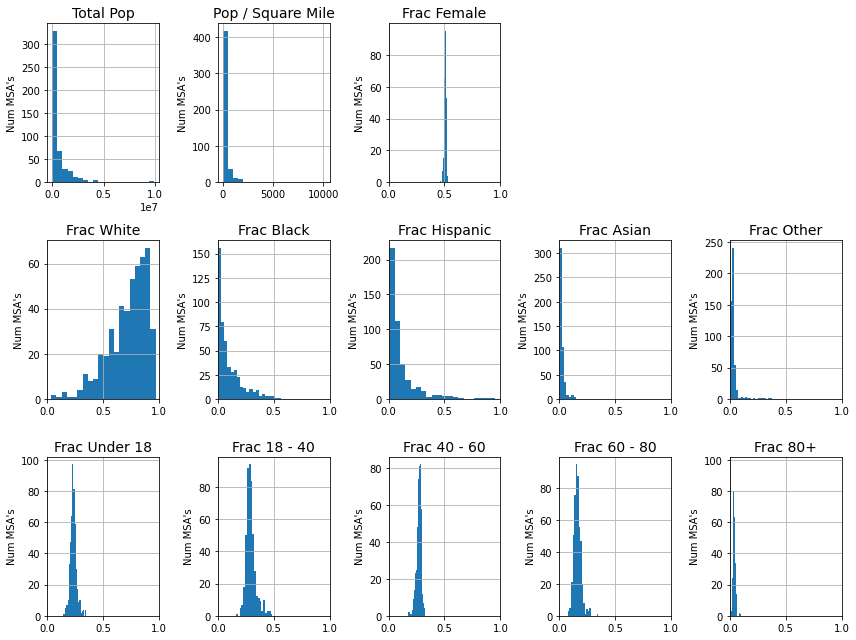

In [120]:
plt.figure(figsize=(12,9))

plt.subplot(3,5,1)
df_msa['Total Pop'].hist(bins=20)
plt.title('Total Pop', fontsize=14)
plt.ylabel('Num MSA\'s')

plt.subplot(3,5,2)
df_msa['pop_density'].hist(bins=20)
plt.title('Pop / Square Mile', fontsize=14)
plt.ylabel('Num MSA\'s')

plt.subplot(3,5,3)
df_msa['frac_female'].hist(bins=20)
plt.title('Frac Female', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,6)
df_msa['frac_white'].hist(bins=20)
plt.title('Frac White', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,7)
df_msa['frac_black'].hist(bins=20)
plt.title('Frac Black', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,8)
df_msa['frac_hispanic'].hist(bins=20)
plt.title('Frac Hispanic', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,9)
df_msa['frac_asian'].hist(bins=20)
plt.title('Frac Asian', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,10)
df_msa['frac_other'].hist(bins=20)
plt.title('Frac Other', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,11)
df_msa['frac_under_18'].hist(bins=20)
plt.title('Frac Under 18', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,12)
df_msa['frac_18_to_40'].hist(bins=20)
plt.title('Frac 18 - 40', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,13)
df_msa['frac_40_to_60'].hist(bins=20)
plt.title('Frac 40 - 60', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,14)
df_msa['frac_60_to_80'].hist(bins=20)
plt.title('Frac 60 - 80', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,15)
df_msa['frac_80_plus'].hist(bins=20)
plt.title('Frac 80+', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.tight_layout()


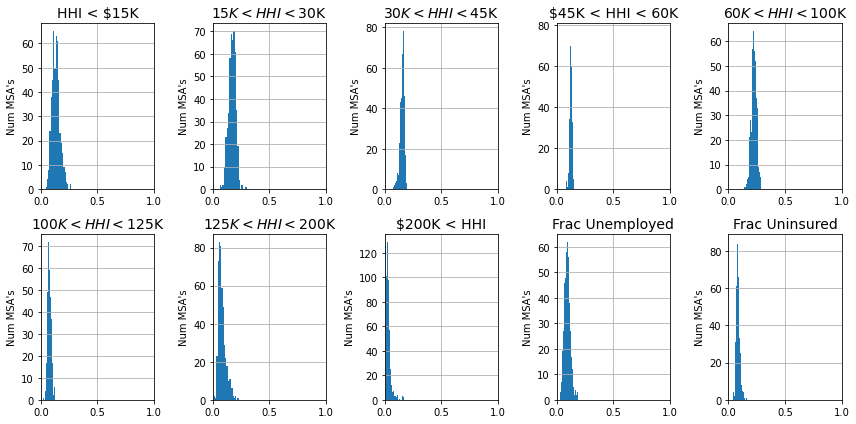

In [121]:
plt.figure(figsize=(12,6))

plt.subplot(2,5,1)
df_msa['frac_lt_15k'].hist(bins=20)
plt.title('HHI < $15K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,2)
df_msa['frac_15k_to_30k'].hist(bins=20)
plt.title('$15K < HHI < $30K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,3)
df_msa['frac_30k_to_45k'].hist(bins=20)
plt.title('$30K < HHI < $45K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,4)
df_msa['frac_45k_to_60k'].hist(bins=20)
plt.title('$45K < HHI < 60K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,5)
df_msa['frac_60k_to_100k'].hist(bins=20)
plt.title('$60K < HHI < $100K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,6)
df_msa['frac_100k_to_125k'].hist(bins=20)
plt.title('$100K < HHI < $125K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,7)
df_msa['frac_125k_to_200k'].hist(bins=20)
plt.title('$125K < HHI < $200K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,8)
df_msa['frac_gt_200k'].hist(bins=20)
plt.title('$200K < HHI', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,9)
df_msa['frac_unemployed'].hist(bins=20)
plt.title('Frac Unemployed', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,10)
df_msa['frac_no_health_insurance'].hist(bins=20)
plt.title('Frac Uninsured', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.tight_layout()


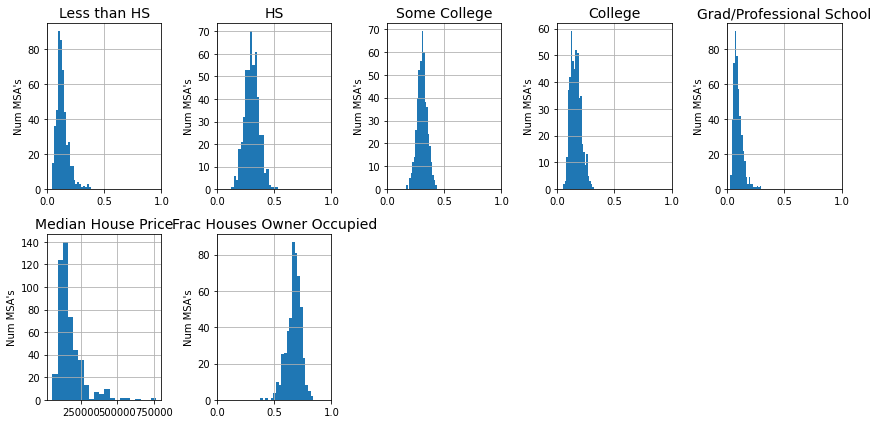

In [122]:
plt.figure(figsize=(12,6))

plt.subplot(2,5,1)
df_msa['frac_lt_hs'].hist(bins=20)
plt.title('Less than HS', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,2)
df_msa['frac_hs'].hist(bins=20)
plt.title('HS', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,3)
df_msa['frac_some_college'].hist(bins=20)
plt.title('Some College', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,4)
df_msa['frac_college'].hist(bins=20)
plt.title('College', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,5)
df_msa['frac_graduate'].hist(bins=20)
plt.title('Grad/Professional School', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,6)
df_msa['median_house_price'].hist(bins=20)
plt.title('Median House Price', fontsize=14)
plt.ylabel('Num MSA\'s')

plt.subplot(2,5,7)
df_msa['frac_houses_owner_occupied'].hist(bins=20)
plt.title('Frac Houses Owner Occupied', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])


plt.tight_layout()

In [123]:
df_msa.to_csv('msa_census_2013.csv')

# do 2019 census data

In [59]:
import censusdata

census_datapoints = {
 'B01003_001E': 'Total Pop',
 'B03002_003E': 'White Pop',
 'B03002_004E': 'Black Pop',
 'B03002_012E': 'Hispanic Pop',
 'B03002_006E': 'Asian Pop',
        
 'B01001_001E': 'Total Population',
 'B01001_002E': 'Male',
 
 'B19001_001E': 'Tot HHs',
 'B19001_002E': 'HH < 10K',
 'B19001_003E': '10k < HH < 15K',
 'B19001_004E': '15k < HH < 20K',
 'B19001_005E': '20k < HH < 25K',
 'B19001_006E': '25k < HH < 30K',
 'B19001_007E': '30k < HH < 35K',
 'B19001_008E': '35k < HH < 40K',
 'B19001_009E': '40k < HH < 45K',
 'B19001_010E': '45k < HH < 50K',
 'B19001_011E': '50k < HH < 60K',
 'B19001_012E': '60k < HH < 75K',
 'B19001_013E': '75k < HH < 100K',
 'B19001_014E': '100k < HH < 125K',
 'B19001_015E': '125k < HH < 150K',
 'B19001_016E': '150k < HH < 200K',
 'B19001_017E': '200k < HH',
 
 'B23025_005E': 'Unemployed Labor Force',
 'B23025_003E': 'Labor Force',
 
 'B06009_001E': 'Education Known',
 'B06009_002E': 'Less than HS',
 'B06009_003E': 'HS',
 'B06009_004E': 'Some College',
 'B06009_005E': 'College',
 'B06009_006E': 'Graduate',
 
 'B25003_001E': 'Houses',
 'B25003_002E': 'Owner-occupied houses',
 
 'B25109_001E': 'Median house price',

 'B27011_001E': 'Insurance Denominator',   
 'B27011_007E': 'Uninsured Numerator 1',
 'B27011_012E': 'Uninsured Numerator 2',
 'B27011_017E': 'Uninsured Numerator 3',
    
# 'B01001_001E': 'Total Population',
 'B01001_003E': 'Under 18 1',
 'B01001_004E': 'Under 18 2',
 'B01001_005E': 'Under 18 3', 
 'B01001_006E': 'Under 18 4',
 'B01001_027E': 'Under 18 5',
 'B01001_028E': 'Under 18 6', 
 'B01001_029E': 'Under 18 7',
 'B01001_030E': 'Under 18 8',
    
 'B01001_007E': '18 - 39 1',
 'B01001_008E': '18 - 39 2',    
 'B01001_009E': '18 - 39 3',  
 'B01001_010E': '18 - 39 4',
 'B01001_011E': '18 - 39 5',    
 'B01001_012E': '18 - 39 6',    
 'B01001_013E': '18 - 39 7',  
 'B01001_031E': '18 - 39 8',
 'B01001_032E': '18 - 39 9',    
 'B01001_033E': '18 - 39 10',  
 'B01001_034E': '18 - 39 11',
 'B01001_035E': '18 - 39 12',    
 'B01001_036E': '18 - 39 13',    
 'B01001_037E': '18 - 39 14',
    
 'B01001_014E': '40 - 64 1',
 'B01001_015E': '40 - 64 2',    
 'B01001_016E': '40 - 64 3',  
 'B01001_017E': '40 - 64 4',
 'B01001_018E': '40 - 64 5',
 'B01001_019E': '40 - 64 6', 
 'B01001_038E': '40 - 64 7',    
 'B01001_039E': '40 - 64 8',    
 'B01001_040E': '40 - 64 9',  
 'B01001_041E': '40 - 64 10',
 'B01001_042E': '40 - 64 11',
 'B01001_043E': '40 - 64 12'#,
    
# 'B01001_020E': 'over 65 1',  
# 'B01001_021E': 'over 65 2',
# 'B01001_022E': 'over 65 3',    
# 'B01001_023E': 'over 65 4', 
# 'B01001_044E': 'over 65 5',  
# 'B01001_045E': 'over 65 6',
# 'B01001_046E': 'over 65 7',    
# 'B01001_047E': 'over 65 8'
 }
        

state_codes = [      '01', '02',       '04', '05', '06',       '08', '09',
               '10', '11', '12', '13',       '15', '16', '17', '18', '19', 
               '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
               '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
               '40', '41', '42',       '44', '45', '46', '47', '48', '49',
               '50', '51',       '53', '54', '55', '56'
              ]
    
state_data = []
for state in state_codes:
    state_data.append(censusdata.download('acs5', 2019, censusdata.censusgeo([('state', state) , 
                                        ('county', '*')]), 
                                         list(census_datapoints.keys())))
df = pd.concat(state_data)
df['Census ID'] = df.index


In [60]:
df['County Code'] = df['Census ID'].apply(lambda x: str(x).split('county:')[-1][:3])
df['State Code'] = df['Census ID'].apply(lambda x: str(x).split('state:')[-1][:2])
df['County'] = df['Census ID'].apply(lambda x: str(x).split(', ')[0][:-7])
df['State'] = df['Census ID'].apply(lambda x: str(x).split(', ')[1].split(':')[0])

In [61]:
state_data = []
for state in state_codes:
    gazeteer_url = 'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2019_Gazetteer/2019_gaz_tracts_' + state + '.txt'
    census_tract_geometry = pd.read_table(gazeteer_url)
    state_data.append(census_tract_geometry)
    
df_geo = pd.concat(state_data)
df_geo.rename(columns={'ALAND_SQMI':'Square Miles'}, inplace=True)

In [62]:
df_geo['county code'] = np.mod(np.floor(df_geo['GEOID']/1000000),1000).astype(int)
df_geo['state code'] = np.floor(np.floor(df_geo['GEOID']/1000000)/1000).astype(int)

df_geo = pd.DataFrame(df_geo.groupby(['state code', 'county code'])['Square Miles'].sum()).reset_index()

In [63]:
df.shape

(3142, 78)

In [64]:
df['state code'] = df['State Code'].astype(int)
df['county code'] = df['County Code'].astype(int)
df=pd.merge(df, df_geo, on=['state code', 'county code'])

In [65]:
df.shape

(3142, 81)

In [66]:
# clean up

df = df.rename(columns=census_datapoints)

df['frac_female'] = 1 - df['Male'] / df['Total Population']

df['frac_white'] = df['White Pop'] / df['Total Pop']
df['frac_black'] = df['Black Pop'] / df['Total Pop']
df['frac_hispanic'] = df['Hispanic Pop'] / df['Total Pop']
df['frac_asian'] = df['Asian Pop'] / df['Total Pop']
df['frac_other'] = 1 - df.frac_white - df.frac_black - df.frac_hispanic - df.frac_asian

df['frac_under_18'] = (df['Under 18 1'] + df['Under 18 2'] + df['Under 18 3'] + df['Under 18 4'] + df['Under 18 5'] + df['Under 18 6'] + df['Under 18 7'] + df['Under 18 8']) / df['Total Population']
df['frac_18_to_39'] = (df['18 - 39 1'] + df['18 - 39 2'] + df['18 - 39 3'] + df['18 - 39 4'] + df['18 - 39 5'] + df['18 - 39 6'] + df['18 - 39 7'] + df['18 - 39 8'] + df['18 - 39 9'] + df['18 - 39 10'] + df['18 - 39 11'] + df['18 - 39 12'] + df['18 - 39 13'] + df['18 - 39 14']) / df['Total Population']
df['frac_40_to_64'] = (df['40 - 64 1'] + df['40 - 64 2'] + df['40 - 64 3'] + df['40 - 64 4'] + df['40 - 64 5'] + df['40 - 64 6'] + df['40 - 64 7'] + df['40 - 64 8'] + df['40 - 64 9'] + df['40 - 64 10'] + df['40 - 64 11'] + df['40 - 64 12']) / df['Total Population']
df['frac_over_65'] = 1 - df.frac_under_18 - df.frac_18_to_39 - df.frac_40_to_64 

#df['frac_lt_15k'] = (df['HH < 10K'] + df['10k < HH < 15K']) / df['Tot HHs']
#df['frac_15k_to_30k'] = (df['15k < HH < 20K'] + df['20k < HH < 25K'] + df['25k < HH < 30K']) / df['Tot HHs']
#df['frac_30k_to_45k'] = (df['30k < HH < 35K'] + df['35k < HH < 40K'] + df['40k < HH < 45K']) / df['Tot HHs']
#df['frac_45k_to_60k'] = (df['45k < HH < 50K'] + df['50k < HH < 60K']) / df['Tot HHs']
#df['frac_60k_to_100k'] = (df['60k < HH < 75K'] + df['75k < HH < 100K']) / df['Tot HHs']
#df['frac_100k_to_125k'] = (df['100k < HH < 125K'] ) / df['Tot HHs']
#df['frac_125k_to_200k'] = (df['125k < HH < 150K'] + df['150k < HH < 200K']) / df['Tot HHs']
#df['frac_gt_200k'] = (df['200k < HH']) / df['Tot HHs']

df['frac_lt_20k'] = (df['HH < 10K'] + df['10k < HH < 15K'] + df['15k < HH < 20K']) / df['Tot HHs']
df['frac_20k_to_40k'] = (df['20k < HH < 25K'] + df['25k < HH < 30K'] + df['30k < HH < 35K'] + df['35k < HH < 40K']) / df['Tot HHs']
df['frac_40k_to_75k'] = (df['40k < HH < 45K'] + df['45k < HH < 50K'] + df['50k < HH < 60K'] + df['60k < HH < 75K']) / df['Tot HHs']
df['frac_75k_to_125k'] = (df['75k < HH < 100K'] + df['100k < HH < 125K'] ) / df['Tot HHs']
df['frac_125k_to_200k'] = (df['125k < HH < 150K'] + df['150k < HH < 200K']) / df['Tot HHs']
df['frac_gt_200k'] = (df['200k < HH']) / df['Tot HHs']

df['frac_unemployed'] = df['Unemployed Labor Force'] / df['Labor Force']
df['frac_no_health_insurance'] = (df['Uninsured Numerator 1'] + df['Uninsured Numerator 2'] + df['Uninsured Numerator 3'])/df['Insurance Denominator']

df['frac_lt_hs'] = df['Less than HS'] / df['Education Known']
df['frac_hs'] = df['HS'] / df['Education Known']
df['frac_some_college'] = df['Some College'] / df['Education Known']
df['frac_college'] = df['College'] / df['Education Known']
df['frac_graduate'] = df['Graduate'] / df['Education Known']

df['frac_houses_owner_occupied'] = df['Owner-occupied houses'] / df['Houses']

df['pop_density'] = df['Total Pop'] / df['Square Miles']

df['median_house_price'] = df['Median house price']

df = df[['County Code', 'County', 'State Code', 'State', 'Square Miles',
     'Total Pop', 'pop_density','frac_female', 
     'frac_white', 'frac_black', 'frac_hispanic', 'frac_asian', 'frac_other',
     'frac_under_18', 'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
     'frac_lt_20k', 'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k',
          'frac_125k_to_200k', 'frac_gt_200k', 
     'frac_unemployed',  'frac_no_health_insurance',
     'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college', 'frac_graduate',
     'frac_houses_owner_occupied', 
     'median_house_price']]

df.loc[df.median_house_price < 0, 'median_house_price'] = df.loc[df.median_house_price > 0, 'median_house_price'].min()

In [67]:
df

,County Code,County,State Code,State,Square Miles,Total Pop,pop_density,frac_female,frac_white,frac_black,...,frac_gt_200k,frac_unemployed,frac_no_health_insurance,frac_lt_hs,frac_hs,frac_some_college,frac_college,frac_graduate,frac_houses_owner_occupied,median_house_price
0,115,St. Clair,01,Alabama,631.582,87989,139.315243,0.499790,0.858698,0.095671,...,0.025690,0.053370,0.136031,0.154467,0.355708,0.328976,0.106017,0.054832,0.798945,154900
1,043,Cullman,01,Alabama,734.742,82853,112.764753,0.508056,0.918844,0.012480,...,0.021847,0.050883,0.179267,0.184458,0.340713,0.336174,0.088712,0.049943,0.748083,128600
2,069,Houston,01,Alabama,579.854,104702,180.566143,0.520640,0.664553,0.267626,...,0.039734,0.064175,0.169608,0.139559,0.312442,0.330933,0.134102,0.082965,0.657043,137600
3,125,Tuscaloosa,01,Alabama,1320.861,207305,156.946870,0.517590,0.615484,0.318917,...,0.041015,0.058140,0.105477,0.116508,0.298940,0.277244,0.183843,0.123466,0.637460,170400
4,031,Coffee,01,Alabama,678.985,51662,76.087101,0.506814,0.701463,0.168015,...,0.030717,0.057399,0.153272,0.140736,0.272434,0.358910,0.152835,0.075086,0.657448,147400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,023,Lincoln,56,Wyoming,4075.337,19274,4.729425,0.491491,0.921760,0.000467,...,0.040677,0.051311,0.196239,0.072200,0.318445,0.372575,0.166536,0.070244,0.824117,246400
3138,025,Natrona,56,Wyoming,5340.541,80333,15.042109,0.497815,0.866892,0.010755,...,0.048050,0.043228,0.183231,0.075337,0.303335,0.393349,0.145303,0.082676,0.681820,208700
3139,009,Converse,56,Wyoming,4254.963,13921,3.271709,0.485023,0.886862,0.000000,...,0.039606,0.054108,0.126513,0.092075,0.389531,0.345701,0.111835,0.060858,0.737077,206700
3140,027,Niobrara,56,Wyoming,2626.028,2422,0.922305,0.549546,0.906276,0.005780,...,0.028008,0.044467,0.227231,0.129032,0.346638,0.343904,0.144888,0.035539,0.774896,156300


In [68]:
ls

MSA Roll-Up.ipynb          crosswalk_before_2013.csv
Untitled.ipynb             msa_census_2013.csv
cbsa_2009.xls              msa_census_2018.csv
cbsa_2013.xls              msa_census_2019.csv
codes.xlsx                 notes_03_21.docx
crosswalk_after_2014.csv


In [69]:
df_crosswalk = pd.read_csv('crosswalk_after_2014.csv')

In [70]:
df_crosswalk.groupby(['MSA', 'EGEOLOC']).size().describe()

count    503.000000
mean       6.248509
std       15.128792
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max      172.000000
dtype: float64

In [71]:
df['FIPS County Code'] = df['County Code'].astype(int)
df['FIPS State Code'] = df['State Code'].astype(int)

df_temp = pd.merge(df, df_crosswalk, on = ['FIPS State Code', 'FIPS County Code'])

In [72]:
#double check that distributions aren't that different after all this rolling up

In [73]:
sum_metrics = ['Total Pop', 'Square Miles']
average_metrics = [ 'frac_female', 
     'frac_white', 'frac_black', 'frac_hispanic', 'frac_asian', 'frac_other',
      'frac_under_18', 'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
     'frac_lt_20k', 'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k',
          'frac_125k_to_200k', 'frac_gt_200k', 
     'frac_unemployed',  'frac_no_health_insurance',
     'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college', 'frac_graduate',
     'frac_houses_owner_occupied', 
     'median_house_price'
]

def rollup_sum(group, column):
    x = group[column]
    return (x).sum()

def rollup_avg(group, column, weight):
    x = group[column]
    w = group[weight]
    return (x * w).sum() /  w.sum()

df_msa = df_temp[['MSA', 'EGEOLOC']].drop_duplicates().reset_index()[['MSA', 'EGEOLOC']]

for column in sum_metrics:
    df_msa = pd.merge(df_msa, pd.DataFrame(df_temp.groupby(['MSA', 'EGEOLOC']).apply(rollup_sum, column), 
                               columns = [column]), on=['MSA', 'EGEOLOC'])
    
for column in average_metrics:
    df_msa = pd.merge(df_msa, pd.DataFrame(df_temp.groupby(['MSA', 'EGEOLOC']).apply(rollup_avg, column, 'Total Pop'), 
                               columns = [column]), on=['MSA', 'EGEOLOC'])

df_msa['pop_density'] = df_msa['Total Pop'] / df_msa['Square Miles']

In [74]:
df_state = df_crosswalk[['EGEOLOC', 'State Name']].drop_duplicates()

In [75]:
df_msa = pd.merge(df_msa, df_state, on='EGEOLOC')

In [76]:
df_msa

,MSA,EGEOLOC,Total Pop,Square Miles,frac_female,frac_white,frac_black,frac_hispanic,frac_asian,frac_other,...,frac_no_health_insurance,frac_lt_hs,frac_hs,frac_some_college,frac_college,frac_graduate,frac_houses_owner_occupied,median_house_price,pop_density,State Name
0,13820,41,1149440,5279.530,0.518941,0.635148,0.287359,0.044257,0.014080,0.019156,...,0.134690,0.113464,0.278937,0.304196,0.190474,0.112929,0.696276,160672.659382,217.716350,Alabama
1,0,41,1142642,28989.209,0.511897,0.685226,0.237991,0.047759,0.005439,0.023586,...,0.170673,0.187666,0.361954,0.295389,0.098298,0.056693,0.708220,105263.906280,39.416115,Alabama
2,20020,41,148252,1716.084,0.518765,0.698689,0.236469,0.033585,0.007366,0.023892,...,0.178134,0.157457,0.322394,0.324871,0.120131,0.075148,0.688638,128887.778242,86.389711,Alabama
3,46220,41,242357,2846.193,0.518570,0.595432,0.342346,0.035860,0.013946,0.012416,...,0.111335,0.124875,0.313255,0.278522,0.171272,0.112077,0.654461,159230.159228,85.151288,Alabama
4,23460,41,102748,535.089,0.517616,0.778614,0.154368,0.038755,0.007436,0.020828,...,0.163681,0.154473,0.328576,0.339044,0.109660,0.068247,0.725874,113700.000000,192.020393,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,20260,20,43295,1304.291,0.497402,0.916203,0.013974,0.016099,0.012426,0.041298,...,0.088353,0.062708,0.311211,0.384700,0.163424,0.077957,0.675241,145800.000000,33.194279,Wisconsin
499,27500,20,162152,718.147,0.507407,0.828346,0.043145,0.086999,0.012445,0.029065,...,0.086469,0.092391,0.361264,0.324966,0.147387,0.073993,0.683576,146200.000000,225.792212,Wisconsin
500,16940,59,98320,2685.865,0.492911,0.788456,0.019864,0.146247,0.011808,0.033625,...,0.116022,0.069983,0.257680,0.387181,0.177998,0.107159,0.697830,227900.000000,36.606456,Wyoming
501,0,59,402371,89062.304,0.488027,0.848163,0.005905,0.089905,0.008152,0.047876,...,0.162921,0.066364,0.295603,0.356943,0.180104,0.100986,0.712540,254549.609689,4.517860,Wyoming


In [77]:
#check a bunch of those distributions

(0.0, 10597348.65)

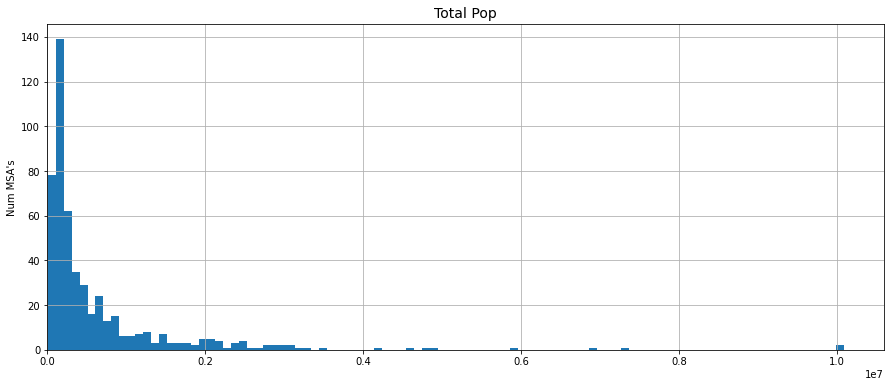

In [78]:
plt.figure(figsize=(15,6))

df_msa['Total Pop'].hist(bins=100)
plt.title('Total Pop', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,df_msa['Total Pop'].max()*1.05])

In [79]:
df_msa['Total Pop'].describe()

count    5.030000e+02
mean     6.454776e+05
std      1.071292e+06
min      6.260000e+03
25%      1.325330e+05
50%      2.580290e+05
75%      6.979865e+05
max      1.009271e+07
Name: Total Pop, dtype: float64

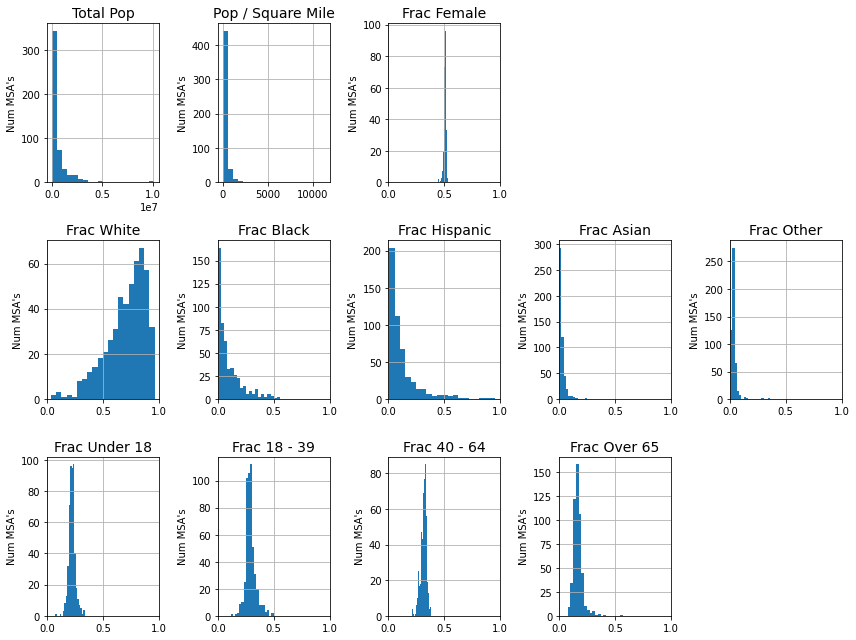

In [80]:
plt.figure(figsize=(12,9))

plt.subplot(3,5,1)
df_msa['Total Pop'].hist(bins=20)
plt.title('Total Pop', fontsize=14)
plt.ylabel('Num MSA\'s')

plt.subplot(3,5,2)
df_msa['pop_density'].hist(bins=20)
plt.title('Pop / Square Mile', fontsize=14)
plt.ylabel('Num MSA\'s')

plt.subplot(3,5,3)
df_msa['frac_female'].hist(bins=20)
plt.title('Frac Female', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,6)
df_msa['frac_white'].hist(bins=20)
plt.title('Frac White', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,7)
df_msa['frac_black'].hist(bins=20)
plt.title('Frac Black', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,8)
df_msa['frac_hispanic'].hist(bins=20)
plt.title('Frac Hispanic', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,9)
df_msa['frac_asian'].hist(bins=20)
plt.title('Frac Asian', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,10)
df_msa['frac_other'].hist(bins=20)
plt.title('Frac Other', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,11)
df_msa['frac_under_18'].hist(bins=20)
plt.title('Frac Under 18', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,12)
df_msa['frac_18_to_39'].hist(bins=20)
plt.title('Frac 18 - 39', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,13)
df_msa['frac_40_to_64'].hist(bins=20)
plt.title('Frac 40 - 64', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(3,5,14)
df_msa['frac_over_65'].hist(bins=20)
plt.title('Frac Over 65', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])


plt.tight_layout()


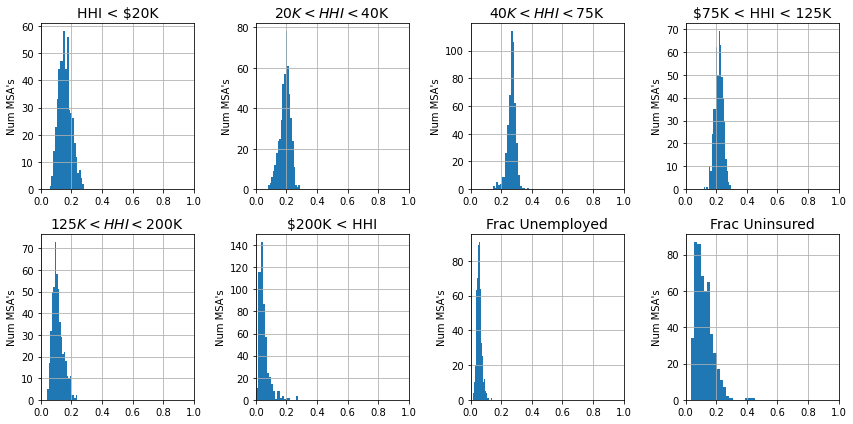

In [81]:
plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
df_msa['frac_lt_20k'].hist(bins=20)
plt.title('HHI < $20K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,4,2)
df_msa['frac_20k_to_40k'].hist(bins=20)
plt.title('$20K < HHI < $40K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,4,3)
df_msa['frac_40k_to_75k'].hist(bins=20)
plt.title('$40K < HHI < $75K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,4,4)
df_msa['frac_75k_to_125k'].hist(bins=20)
plt.title('$75K < HHI < 125K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,4,5)
df_msa['frac_125k_to_200k'].hist(bins=20)
plt.title('$125K < HHI < $200K', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,4,6)
df_msa['frac_gt_200k'].hist(bins=20)
plt.title('$200K < HHI', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,4,7)
df_msa['frac_unemployed'].hist(bins=20)
plt.title('Frac Unemployed', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,4,8)
df_msa['frac_no_health_insurance'].hist(bins=20)
plt.title('Frac Uninsured', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.tight_layout()


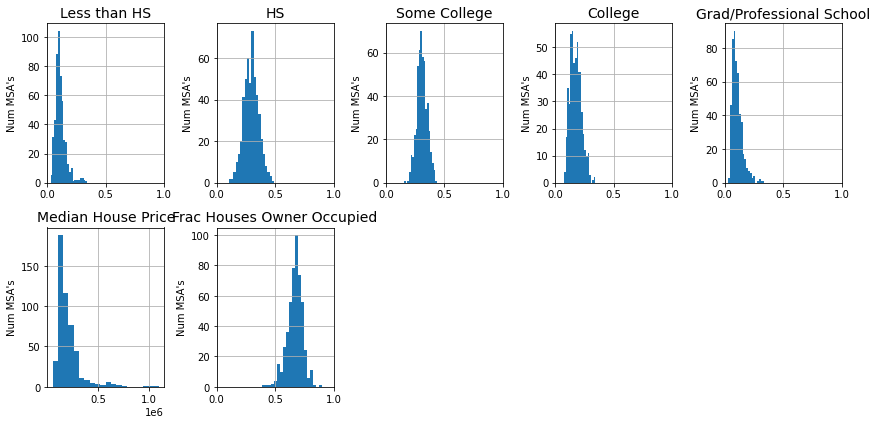

In [82]:
plt.figure(figsize=(12,6))

plt.subplot(2,5,1)
df_msa['frac_lt_hs'].hist(bins=20)
plt.title('Less than HS', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,2)
df_msa['frac_hs'].hist(bins=20)
plt.title('HS', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,3)
df_msa['frac_some_college'].hist(bins=20)
plt.title('Some College', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,4)
df_msa['frac_college'].hist(bins=20)
plt.title('College', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,5)
df_msa['frac_graduate'].hist(bins=20)
plt.title('Grad/Professional School', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])

plt.subplot(2,5,6)
df_msa['median_house_price'].hist(bins=20)
plt.title('Median House Price', fontsize=14)
plt.ylabel('Num MSA\'s')

plt.subplot(2,5,7)
df_msa['frac_houses_owner_occupied'].hist(bins=20)
plt.title('Frac Houses Owner Occupied', fontsize=14)
plt.ylabel('Num MSA\'s')
plt.xlim([0,1])


plt.tight_layout()

In [83]:
df_msa.to_csv('msa_census_2019.csv')

In [84]:
df_msa

,MSA,EGEOLOC,Total Pop,Square Miles,frac_female,frac_white,frac_black,frac_hispanic,frac_asian,frac_other,...,frac_no_health_insurance,frac_lt_hs,frac_hs,frac_some_college,frac_college,frac_graduate,frac_houses_owner_occupied,median_house_price,pop_density,State Name
0,13820,41,1149440,5279.530,0.518941,0.635148,0.287359,0.044257,0.014080,0.019156,...,0.134690,0.113464,0.278937,0.304196,0.190474,0.112929,0.696276,160672.659382,217.716350,Alabama
1,0,41,1142642,28989.209,0.511897,0.685226,0.237991,0.047759,0.005439,0.023586,...,0.170673,0.187666,0.361954,0.295389,0.098298,0.056693,0.708220,105263.906280,39.416115,Alabama
2,20020,41,148252,1716.084,0.518765,0.698689,0.236469,0.033585,0.007366,0.023892,...,0.178134,0.157457,0.322394,0.324871,0.120131,0.075148,0.688638,128887.778242,86.389711,Alabama
3,46220,41,242357,2846.193,0.518570,0.595432,0.342346,0.035860,0.013946,0.012416,...,0.111335,0.124875,0.313255,0.278522,0.171272,0.112077,0.654461,159230.159228,85.151288,Alabama
4,23460,41,102748,535.089,0.517616,0.778614,0.154368,0.038755,0.007436,0.020828,...,0.163681,0.154473,0.328576,0.339044,0.109660,0.068247,0.725874,113700.000000,192.020393,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,20260,20,43295,1304.291,0.497402,0.916203,0.013974,0.016099,0.012426,0.041298,...,0.088353,0.062708,0.311211,0.384700,0.163424,0.077957,0.675241,145800.000000,33.194279,Wisconsin
499,27500,20,162152,718.147,0.507407,0.828346,0.043145,0.086999,0.012445,0.029065,...,0.086469,0.092391,0.361264,0.324966,0.147387,0.073993,0.683576,146200.000000,225.792212,Wisconsin
500,16940,59,98320,2685.865,0.492911,0.788456,0.019864,0.146247,0.011808,0.033625,...,0.116022,0.069983,0.257680,0.387181,0.177998,0.107159,0.697830,227900.000000,36.606456,Wyoming
501,0,59,402371,89062.304,0.488027,0.848163,0.005905,0.089905,0.008152,0.047876,...,0.162921,0.066364,0.295603,0.356943,0.180104,0.100986,0.712540,254549.609689,4.517860,Wyoming


In [85]:
df_temp1 = df_msa[(df_msa.MSA != 0) & (np.mod(df_msa.MSA,10) == 0)][['MSA']].drop_duplicates()
df_temp2 = df_msa[(np.mod(df_msa.MSA,10) == 4)][['MSA']].drop_duplicates()
                                       
df_xwalk[df_xwalk['Metro Division Code'].isna()]


,CBSA Code,Metro Division Code,CSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,Metropolitan Division Title,CSA Title,County/County Equivalent,State Name,FIPS State Code,FIPS County Code,Central/Outlying County
0,10100,NaN,NaN,"Aberdeen, SD",Micropolitan Statistical Area,NaN,NaN,Brown County,South Dakota,46.0,13.0,Central
1,10100,NaN,NaN,"Aberdeen, SD",Micropolitan Statistical Area,NaN,NaN,Edmunds County,South Dakota,46.0,45.0,Outlying
2,10140,NaN,NaN,"Aberdeen, WA",Micropolitan Statistical Area,NaN,NaN,Grays Harbor County,Washington,53.0,27.0,Central
3,10180,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,NaN,NaN,Callahan County,Texas,48.0,59.0,Outlying
4,10180,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,NaN,NaN,Jones County,Texas,48.0,253.0,Outlying
...,...,...,...,...,...,...,...,...,...,...,...,...
1877,49700,NaN,472.0,"Yuba City, CA",Metropolitan Statistical Area,NaN,"Sacramento-Roseville, CA",Sutter County,California,6.0,101.0,Central
1878,49700,NaN,472.0,"Yuba City, CA",Metropolitan Statistical Area,NaN,"Sacramento-Roseville, CA",Yuba County,California,6.0,115.0,Central
1879,49740,NaN,NaN,"Yuma, AZ",Metropolitan Statistical Area,NaN,NaN,Yuma County,Arizona,4.0,27.0,Central
1880,49780,NaN,198.0,"Zanesville, OH",Micropolitan Statistical Area,NaN,"Columbus-Marion-Zanesville, OH",Muskingum County,Ohio,39.0,119.0,Central


In [86]:
df_t1 = pd.merge(df_temp1, df_xwalk[['CBSA Code', 'CBSA Title']], left_on = 'MSA', right_on = 'CBSA Code').rename(columns={'CBSA Title': 'Name'})
df_t2 = pd.merge(df_temp2, df_xwalk[['Metro Division Code', 'Metropolitan Division Title']], left_on = 'MSA', right_on = 'Metro Division Code').rename(columns={'Metropolitan Division Title': 'Name'})
df_names = pd.concat([df_t1[['MSA', 'Name']], df_t2[['MSA', 'Name']]])

In [87]:
df_msa_names = pd.merge(df_msa, df_names.drop_duplicates(), how='left', on = 'MSA')
df_msa_names.loc[df_msa_names.MSA == 0, 'Name'] = 'Rural'
df_msa_names.to_csv('msa_census_2019.csv')

# do zip code 2019, with PCA

In [95]:
import censusdata

census_datapoints = {
 'B01003_001E': 'Total Pop',
 'B03002_003E': 'White Pop',
 'B03002_004E': 'Black Pop',
 'B03002_012E': 'Hispanic Pop',
 'B03002_006E': 'Asian Pop',
        
 'B01001_001E': 'Total Population',
 'B01001_002E': 'Male',
 
 'B19001_001E': 'Tot HHs',
 'B19001_002E': 'HH < 10K',
 'B19001_003E': '10k < HH < 15K',
 'B19001_004E': '15k < HH < 20K',
 'B19001_005E': '20k < HH < 25K',
 'B19001_006E': '25k < HH < 30K',
 'B19001_007E': '30k < HH < 35K',
 'B19001_008E': '35k < HH < 40K',
 'B19001_009E': '40k < HH < 45K',
 'B19001_010E': '45k < HH < 50K',
 'B19001_011E': '50k < HH < 60K',
 'B19001_012E': '60k < HH < 75K',
 'B19001_013E': '75k < HH < 100K',
 'B19001_014E': '100k < HH < 125K',
 'B19001_015E': '125k < HH < 150K',
 'B19001_016E': '150k < HH < 200K',
 'B19001_017E': '200k < HH',
 
 'B23025_005E': 'Unemployed Labor Force',
 'B23025_003E': 'Labor Force',
 
 'B06009_001E': 'Education Known',
 'B06009_002E': 'Less than HS',
 'B06009_003E': 'HS',
 'B06009_004E': 'Some College',
 'B06009_005E': 'College',
 'B06009_006E': 'Graduate',
 
 'B25003_001E': 'Houses',
 'B25003_002E': 'Owner-occupied houses',
 
 'B25109_001E': 'Median house price',

 'B27011_001E': 'Insurance Denominator',   
 'B27011_007E': 'Uninsured Numerator 1',
 'B27011_012E': 'Uninsured Numerator 2',
 'B27011_017E': 'Uninsured Numerator 3',
    
# 'B01001_001E': 'Total Population',
 'B01001_003E': 'Under 18 1',
 'B01001_004E': 'Under 18 2',
 'B01001_005E': 'Under 18 3', 
 'B01001_006E': 'Under 18 4',
 'B01001_027E': 'Under 18 5',
 'B01001_028E': 'Under 18 6', 
 'B01001_029E': 'Under 18 7',
 'B01001_030E': 'Under 18 8',
    
 'B01001_007E': '18 - 39 1',
 'B01001_008E': '18 - 39 2',    
 'B01001_009E': '18 - 39 3',  
 'B01001_010E': '18 - 39 4',
 'B01001_011E': '18 - 39 5',    
 'B01001_012E': '18 - 39 6',    
 'B01001_013E': '18 - 39 7',  
 'B01001_031E': '18 - 39 8',
 'B01001_032E': '18 - 39 9',    
 'B01001_033E': '18 - 39 10',  
 'B01001_034E': '18 - 39 11',
 'B01001_035E': '18 - 39 12',    
 'B01001_036E': '18 - 39 13',    
 'B01001_037E': '18 - 39 14',
    
 'B01001_014E': '40 - 64 1',
 'B01001_015E': '40 - 64 2',    
 'B01001_016E': '40 - 64 3',  
 'B01001_017E': '40 - 64 4',
 'B01001_018E': '40 - 64 5',
 'B01001_019E': '40 - 64 6', 
 'B01001_038E': '40 - 64 7',    
 'B01001_039E': '40 - 64 8',    
 'B01001_040E': '40 - 64 9',  
 'B01001_041E': '40 - 64 10',
 'B01001_042E': '40 - 64 11',
 'B01001_043E': '40 - 64 12'#,
    
# 'B01001_020E': 'over 65 1',  
# 'B01001_021E': 'over 65 2',
# 'B01001_022E': 'over 65 3',    
# 'B01001_023E': 'over 65 4', 
# 'B01001_044E': 'over 65 5',  
# 'B01001_045E': 'over 65 6',
# 'B01001_046E': 'over 65 7',    
# 'B01001_047E': 'over 65 8'
 }
        

state_codes = [      '01', '02',       '04', '05', '06',       '08', '09',
               '10', '11', '12', '13',       '15', '16', '17', '18', '19', 
               '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
               '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
               '40', '41', '42',       '44', '45', '46', '47', '48', '49',
               '50', '51',       '53', '54', '55', '56'
              ]
    
state_data = []
for state in state_codes:
    state_data.append(censusdata.download('acs5', 2019, censusdata.censusgeo([('state', state) , 
                                        ('county', '*'),
                                         ('tract', '*')]), 
                                         list(census_datapoints.keys())))
df = pd.concat(state_data)
df['Census ID'] = df.index
df['Tract'] = df['Census ID'].apply(lambda x: str(x).split('tract:')[-1]) #.astype(int)
df['County Code'] = df['Census ID'].apply(lambda x: str(x).split('county:')[-1][:3])
df['State Code'] = df['Census ID'].apply(lambda x: str(x).split('state:')[-1][:2])
df['County'] = df['Census ID'].apply(lambda x: str(x).split(', ')[1][:-7])
df['State'] = df['Census ID'].apply(lambda x: str(x).split(', ')[2].split(':')[0])
df['GEOID'] = (df['State Code'] + df['County Code'] + df['Tract'].astype(str)).astype(int)
del df['Census ID']

In [96]:
#download the square mileage of each zip code

state_data = []
for state in state_codes:
    gazeteer_url = 'https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2019_Gazetteer/2019_gaz_tracts_' + state + '.txt'
    census_tract_geometry = pd.read_table(gazeteer_url)
    state_data.append(census_tract_geometry)
    
df_geo = pd.concat(state_data)
df_geo.rename(columns={'ALAND_SQMI':'Square Miles'}, inplace=True)

df = pd.merge(df,df_geo[['GEOID', 'Square Miles']], on='GEOID')

df = df[df['Square Miles'] > 0]


In [97]:
# clean up

df = df.rename(columns=census_datapoints)

df['frac_female'] = 1 - df['Male'] / df['Total Population']

df['frac_white'] = df['White Pop'] / df['Total Pop']
df['frac_black'] = df['Black Pop'] / df['Total Pop']
df['frac_hispanic'] = df['Hispanic Pop'] / df['Total Pop']
df['frac_asian'] = df['Asian Pop'] / df['Total Pop']
df['frac_other'] = 1 - df.frac_white - df.frac_black - df.frac_hispanic - df.frac_asian

df['frac_under_18'] = (df['Under 18 1'] + df['Under 18 2'] + df['Under 18 3'] + df['Under 18 4'] + df['Under 18 5'] + df['Under 18 6'] + df['Under 18 7'] + df['Under 18 8']) / df['Total Population']
df['frac_18_to_39'] = (df['18 - 39 1'] + df['18 - 39 2'] + df['18 - 39 3'] + df['18 - 39 4'] + df['18 - 39 5'] + df['18 - 39 6'] + df['18 - 39 7'] + df['18 - 39 8'] + df['18 - 39 9'] + df['18 - 39 10'] + df['18 - 39 11'] + df['18 - 39 12'] + df['18 - 39 13'] + df['18 - 39 14']) / df['Total Population']
df['frac_40_to_64'] = (df['40 - 64 1'] + df['40 - 64 2'] + df['40 - 64 3'] + df['40 - 64 4'] + df['40 - 64 5'] + df['40 - 64 6'] + df['40 - 64 7'] + df['40 - 64 8'] + df['40 - 64 9'] + df['40 - 64 10'] + df['40 - 64 11'] + df['40 - 64 12']) / df['Total Population']
df['frac_over_65'] = 1 - df.frac_under_18 - df.frac_18_to_39 - df.frac_40_to_64 

#df['frac_lt_15k'] = (df['HH < 10K'] + df['10k < HH < 15K']) / df['Tot HHs']
#df['frac_15k_to_30k'] = (df['15k < HH < 20K'] + df['20k < HH < 25K'] + df['25k < HH < 30K']) / df['Tot HHs']
#df['frac_30k_to_45k'] = (df['30k < HH < 35K'] + df['35k < HH < 40K'] + df['40k < HH < 45K']) / df['Tot HHs']
#df['frac_45k_to_60k'] = (df['45k < HH < 50K'] + df['50k < HH < 60K']) / df['Tot HHs']
#df['frac_60k_to_100k'] = (df['60k < HH < 75K'] + df['75k < HH < 100K']) / df['Tot HHs']
#df['frac_100k_to_125k'] = (df['100k < HH < 125K'] ) / df['Tot HHs']
#df['frac_125k_to_200k'] = (df['125k < HH < 150K'] + df['150k < HH < 200K']) / df['Tot HHs']
#df['frac_gt_200k'] = (df['200k < HH']) / df['Tot HHs']

df['frac_lt_20k'] = (df['HH < 10K'] + df['10k < HH < 15K'] + df['15k < HH < 20K']) / df['Tot HHs']
df['frac_20k_to_40k'] = (df['20k < HH < 25K'] + df['25k < HH < 30K'] + df['30k < HH < 35K'] + df['35k < HH < 40K']) / df['Tot HHs']
df['frac_40k_to_75k'] = (df['40k < HH < 45K'] + df['45k < HH < 50K'] + df['50k < HH < 60K'] + df['60k < HH < 75K']) / df['Tot HHs']
df['frac_75k_to_125k'] = (df['75k < HH < 100K'] + df['100k < HH < 125K'] ) / df['Tot HHs']
df['frac_125k_to_200k'] = (df['125k < HH < 150K'] + df['150k < HH < 200K']) / df['Tot HHs']
df['frac_gt_200k'] = (df['200k < HH']) / df['Tot HHs']

df['frac_unemployed'] = df['Unemployed Labor Force'] / df['Labor Force']
df['frac_no_health_insurance'] = (df['Uninsured Numerator 1'] + df['Uninsured Numerator 2'] + df['Uninsured Numerator 3'])/df['Insurance Denominator']

df['frac_lt_hs'] = df['Less than HS'] / df['Education Known']
df['frac_hs'] = df['HS'] / df['Education Known']
df['frac_some_college'] = df['Some College'] / df['Education Known']
df['frac_college'] = df['College'] / df['Education Known']
df['frac_graduate'] = df['Graduate'] / df['Education Known']

df['frac_houses_owner_occupied'] = df['Owner-occupied houses'] / df['Houses']

df['pop_density'] = df['Total Pop'] / df['Square Miles']

df['median_house_price'] = df['Median house price']

df = df[['GEOID', 'County Code', 'County', 'State Code', 'State', 'Square Miles',
     'Total Pop', 'pop_density','frac_female', 
     'frac_white', 'frac_black', 'frac_hispanic', 'frac_asian', 'frac_other',
     'frac_under_18', 'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
     'frac_lt_20k', 'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k',
          'frac_125k_to_200k', 'frac_gt_200k', 
     'frac_unemployed',  'frac_no_health_insurance',
     'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college', 'frac_graduate',
     'frac_houses_owner_occupied', 
     'median_house_price']]

df.loc[df.median_house_price < 0, 'median_house_price'] = df.loc[df.median_house_price > 0, 'median_house_price'].min()

In [98]:
df_crosswalk = pd.read_excel('TRACT_ZIP_032019.xlsx')

In [99]:
df

,GEOID,County Code,County,State Code,State,Square Miles,Total Pop,pop_density,frac_female,frac_white,...,frac_gt_200k,frac_unemployed,frac_no_health_insurance,frac_lt_hs,frac_hs,frac_some_college,frac_college,frac_graduate,frac_houses_owner_occupied,median_house_price
0,1073001100,073,Jefferson,01,Alabama,4.399,4781,1086.837918,0.600084,0.016105,...,0.000000,0.009207,0.159545,0.082192,0.229224,0.354642,0.247489,0.086454,0.565640,85500
1,1073001400,073,Jefferson,01,Alabama,0.865,1946,2249.710983,0.470709,0.000000,...,0.024510,0.115012,0.285714,0.174254,0.247253,0.407378,0.102041,0.069074,0.620098,67800
2,1073002000,073,Jefferson,01,Alabama,1.392,4080,2931.034483,0.574755,0.277451,...,0.014094,0.137549,0.356416,0.233405,0.304782,0.370093,0.068522,0.023198,0.376321,68400
3,1073003802,073,Jefferson,01,Alabama,1.253,5291,4222.665603,0.546589,0.016065,...,0.000000,0.103332,0.137741,0.143187,0.382794,0.391744,0.079388,0.002887,0.540655,64100
4,1073004000,073,Jefferson,01,Alabama,0.911,2533,2780.461032,0.530596,0.065930,...,0.000000,0.211483,0.287928,0.170472,0.347032,0.383562,0.054287,0.044647,0.261721,67300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73051,56021001902,021,Laramie,56,Wyoming,995.572,4187,4.205622,0.479818,0.932888,...,0.057298,0.043080,0.054976,0.010407,0.223415,0.430244,0.204553,0.131382,0.949337,345200
73052,56021980801,021,Laramie,56,Wyoming,1.386,0,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999
73053,56025001602,025,Natrona,56,Wyoming,5.303,7513,1416.745239,0.488886,0.849594,...,0.129247,0.013818,0.168290,0.123694,0.245926,0.334308,0.197033,0.099039,0.691769,321700
73054,56025001603,025,Natrona,56,Wyoming,18.912,3724,196.912014,0.494629,0.832975,...,0.115532,0.045389,0.120584,0.033160,0.220535,0.343588,0.219337,0.183380,0.964805,334100


In [100]:
df_temp = pd.merge(df, df_crosswalk[['tract', 'zip', 'res_ratio']], left_on = 'GEOID', right_on = 'tract')
df_temp = df_temp[(df_temp['Total Pop'] > 0) & (df_temp['res_ratio'] > 0)]

In [101]:
weighted_sum_metrics = ['Total Pop', 'Square Miles']
weighted_average_metrics = [ 'frac_female',
     'frac_white', 'frac_black', 'frac_hispanic', 'frac_asian', 'frac_other',
    'frac_under_18', 'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
     'frac_lt_20k', 'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k',
          'frac_125k_to_200k', 'frac_gt_200k', 
     'frac_unemployed',  'frac_no_health_insurance',
     'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college', 'frac_graduate',
     'frac_houses_owner_occupied', 
     'median_house_price']

def weighted_sum(group, column, weight):
    x = group[column]
    w = group[weight]
    return (x * w).sum()

def weighted_avg(group, column, weight):
    x = group[column]
    w = group[weight]
    return (x * w).sum() /  w.sum()

df_zip = pd.DataFrame(df_temp.zip.unique(), columns = ['zip'])

for column in weighted_sum_metrics:
    df_zip = pd.merge(df_zip, pd.DataFrame(df_temp.groupby('zip').apply(weighted_sum, column, 'res_ratio'), 
                               columns = [column]), on='zip')
    
for column in weighted_average_metrics:
    df_zip = pd.merge(df_zip, pd.DataFrame(df_temp.groupby('zip').apply(weighted_avg, column, 'res_ratio'), 
                               columns = [column]), on='zip')


In [102]:
df_zip['ZIP'] = df_zip.zip.astype(float)
df_zip = pd.merge(df_zip, df_temp.groupby('zip')['County Code'].agg(lambda x:x.value_counts().index[0]), on='zip', how='left')
df_zip = pd.merge(df_zip, df_temp.groupby('zip')['County'].agg(lambda x:x.value_counts().index[0]), on='zip', how='left')
df_zip = pd.merge(df_zip, df_temp.groupby('zip')['State Code'].agg(lambda x:x.value_counts().index[0]), on='zip', how='left')
df_zip = pd.merge(df_zip, df_temp.groupby('zip')['State'].agg(lambda x:x.value_counts().index[0]), on='zip', how='left')



df_zip['pop_density'] = df_zip['Total Pop'] / df_zip['Square Miles']

In [103]:
df_zip

,zip,Total Pop,Square Miles,frac_female,frac_white,frac_black,frac_hispanic,frac_asian,frac_other,frac_under_18,...,frac_college,frac_graduate,frac_houses_owner_occupied,median_house_price,ZIP,County Code,County,State Code,State,pop_density
0,35228,10293.143006,4.485270,0.553400,0.057527,0.857561,0.062580,0.001179,0.021153,0.247756,...,0.123237,0.028131,0.573577,71983.550057,35228.0,073,Jefferson,01,Alabama,2294.876937
1,35214,17072.143160,33.164212,0.557357,0.206600,0.749724,0.019214,0.008430,0.016031,0.197142,...,0.171495,0.067571,0.700755,104872.863626,35214.0,073,Jefferson,01,Alabama,514.776087
2,35204,10312.324334,4.700888,0.528552,0.048820,0.894343,0.046149,0.002804,0.007884,0.167248,...,0.077265,0.048171,0.391267,65541.588674,35204.0,073,Jefferson,01,Alabama,2193.697256
3,35234,5439.930425,2.305478,0.553772,0.101442,0.879663,0.015966,0.001799,0.001130,0.157418,...,0.078962,0.020400,0.487719,59972.892010,35234.0,073,Jefferson,01,Alabama,2359.566944
4,35210,14633.232997,20.925082,0.554609,0.622672,0.280717,0.052337,0.003810,0.040465,0.223180,...,0.269751,0.156112,0.704532,177835.826131,35210.0,073,Jefferson,01,Alabama,699.315445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34549,82215,309.387097,163.723831,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,0.176259,...,0.135375,0.049960,0.778032,155100.000000,82215.0,031,Platte,56,Wyoming,1.889689
34550,82214,35.870968,18.982473,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,0.176259,...,0.135375,0.049960,0.778032,155100.000000,82214.0,031,Platte,56,Wyoming,1.889689
34551,82213,941.612903,498.289919,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,0.176259,...,0.135375,0.049960,0.778032,155100.000000,82213.0,031,Platte,56,Wyoming,1.889689
34552,82059,209.444344,49.801033,0.479818,0.932888,0.000000,0.042513,0.000000,0.024600,0.216623,...,0.204553,0.131382,0.949337,345200.000000,82059.0,021,Laramie,56,Wyoming,4.205622


In [104]:
df_zip.columns

Index(['zip', 'Total Pop', 'Square Miles', 'frac_female', 'frac_white',
       'frac_black', 'frac_hispanic', 'frac_asian', 'frac_other',
       'frac_under_18', 'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
       'frac_lt_20k', 'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k',
       'frac_125k_to_200k', 'frac_gt_200k', 'frac_unemployed',
       'frac_no_health_insurance', 'frac_lt_hs', 'frac_hs',
       'frac_some_college', 'frac_college', 'frac_graduate',
       'frac_houses_owner_occupied', 'median_house_price', 'ZIP',
       'County Code', 'County', 'State Code', 'State', 'pop_density'],
      dtype='object')

In [151]:
df_zip['total_pop_millions'] = df['Total Pop'] / 1000000
df_zip['log_10_pop_density'] = np.log10(1 + df.pop_density)
df_zip['house_price_millions'] =  df['median_house_price'] / 1000000

In [160]:
features = ['total_pop_millions', 'log_10_pop_density', 
    'frac_asian', 'frac_black', 'frac_hispanic', 'frac_white', 'frac_other',
    'frac_under_18', 'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
       'frac_lt_20k', 'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k',
       'frac_125k_to_200k', 'frac_gt_200k', 'frac_unemployed',
       'frac_no_health_insurance', 'frac_lt_hs', 'frac_hs',
       'frac_some_college', 'frac_college', 'frac_graduate',
       'frac_houses_owner_occupied', 'house_price_millions']

df_temp = df_zip[df_zip.total_pop_millions > 0][features].copy()

In [161]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [162]:
x = StandardScaler().fit_transform(df_temp)

pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)

In [163]:
pca.explained_variance_ratio_

array([0.2490957])

In [164]:
pca.components_

array([[-0.00685842, -0.01725315, -0.14020465,  0.14164099,  0.10286357,
        -0.13515563,  0.0433915 ,  0.06299936,  0.04602997, -0.11011832,
        -0.028276  ,  0.289483  ,  0.31460834,  0.14883203, -0.21534562,
        -0.33098598, -0.30309137,  0.20942847,  0.25214694,  0.29427885,
         0.23511013,  0.04778291, -0.32403309, -0.29436171, -0.11806948,
        -0.01694293]])

In [181]:
df_tt = pd.DataFrame(features, columns=['features'])
df_tt['coef'] = -pca.components_[0]
df_tt['annot'] = np.round(np.round(df_tt.coef*100,0)/100,2)

df_tt.set_index('features', inplace=True)

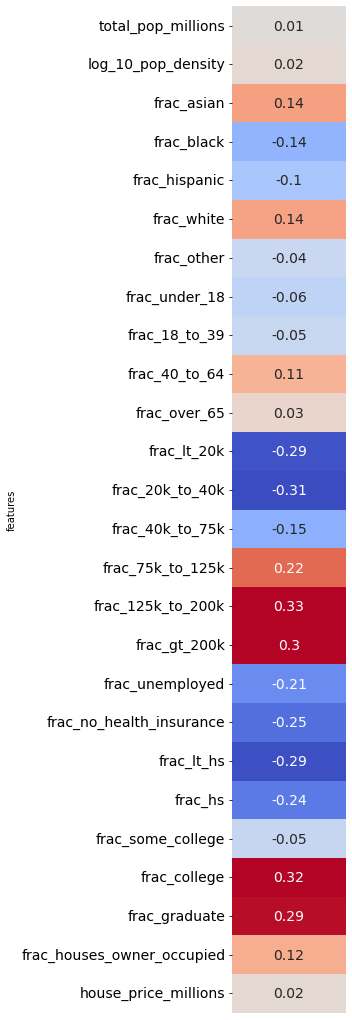

In [218]:
plt.figure(figsize=(5,17 * 3.5/7.5 * 1.8 ))

b = sns.heatmap(df_tt[['coef']],   cmap = 'coolwarm', 
         vmin=-0.3, vmax=0.3,  cbar=False, 
                robust=True,fmt = '', annot = df_tt[['annot']],
                annot_kws={'size':14})
b.set_yticklabels(b.get_yticklabels(), size = 14)
b.set_xticks([])

plt.tight_layout()
plt.savefig('temp.jpg')

In [202]:
df_zip_ses = df_zip[df_zip.total_pop_millions > 0].copy()
df_zip_ses['SES'] = -principalComponents.T[0]

In [219]:
df_zip_ses.to_csv('census_zip_2019_with_pca.csv')

In [203]:
df_crosswalk_2 = pd.read_excel('ZIP_TRACT_092019.xlsx')

In [204]:
df_temp=pd.merge(df_zip_ses, df_crosswalk_2[['tract', 'zip', 'res_ratio']], left_on = 'zip', right_on = 'zip')

In [205]:
df_temp

,zip,Total Pop,Square Miles,frac_female,frac_white,frac_black,frac_hispanic,frac_asian,frac_other,frac_under_18,...,State,pop_density,total_pop_millions,log_10_pop_density,house_price_millions,total_pop_10k,log_10_pop_density_divide_100,SES,tract,res_ratio
0,35228,10293.143006,4.485270,0.553400,0.057527,0.857561,0.062580,0.001179,0.021153,0.247756,...,Alabama,2294.876937,0.004781,3.036564,0.0855,0.4781,0.030366,-4.224270,1073013300,0.296349
1,35228,10293.143006,4.485270,0.553400,0.057527,0.857561,0.062580,0.001179,0.021153,0.247756,...,Alabama,2294.876937,0.004781,3.036564,0.0855,0.4781,0.030366,-4.224270,1073013601,0.070011
2,35228,10293.143006,4.485270,0.553400,0.057527,0.857561,0.062580,0.001179,0.021153,0.247756,...,Alabama,2294.876937,0.004781,3.036564,0.0855,0.4781,0.030366,-4.224270,1073013400,0.174938
3,35228,10293.143006,4.485270,0.553400,0.057527,0.857561,0.062580,0.001179,0.021153,0.247756,...,Alabama,2294.876937,0.004781,3.036564,0.0855,0.4781,0.030366,-4.224270,1073003802,0.183800
4,35228,10293.143006,4.485270,0.553400,0.057527,0.857561,0.062580,0.001179,0.021153,0.247756,...,Alabama,2294.876937,0.004781,3.036564,0.0855,0.4781,0.030366,-4.224270,1073010603,0.000532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162189,82215,309.387097,163.723831,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,0.176259,...,Wyoming,1.889689,0.001622,1.023097,0.0813,0.1622,0.010231,-0.094913,56031959100,1.000000
162190,82214,35.870968,18.982473,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,0.176259,...,Wyoming,1.889689,0.002051,1.581576,0.0952,0.2051,0.015816,-0.082030,56031959100,1.000000
162191,82213,941.612903,498.289919,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,0.176259,...,Wyoming,1.889689,0.002312,1.093418,0.1164,0.2312,0.010934,-0.089438,56031959100,1.000000
162192,82059,209.444344,49.801033,0.479818,0.932888,0.000000,0.042513,0.000000,0.024600,0.216623,...,Wyoming,4.205622,0.003400,1.892861,0.1083,0.3400,0.018929,3.699783,56021001902,1.000000


In [206]:
weighted_average_metrics = ['SES']


def weighted_avg(group, column, weight):
    x = group[column]
    w = group[weight]
    return (x * w).sum() /  w.sum()

df_unroll = pd.DataFrame(df_temp.tract.unique(), columns = ['tract'])

for column in weighted_average_metrics:
    df_unroll = pd.merge(df_unroll, pd.DataFrame(df_temp.groupby('tract').apply(weighted_avg, column, 'res_ratio'), 
                               columns = [column]), on='tract')


In [207]:
import geopandas as gpd
from mpl_toolkits.axes_grid1 import ImageGrid
import us
from shapely.geometry import Point, Polygon

In [208]:
contiguous_states = ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'ID', 'IL', 'IN', 'IA', 'KS',
                     'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 
                     'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
                     'WA', 'WV', 'WI', 'WY']
others = ['AK', 'HI']

state_shapes = pd.DataFrame([])
tract_shapes = pd.DataFrame([])

for state in us.states.STATES:
    if state.abbr in contiguous_states:
        state_shapes = pd.concat([state_shapes, gpd.read_file(state.shapefile_urls('state'))], axis=0)
        tract_shapes = pd.concat([tract_shapes, gpd.read_file(state.shapefile_urls('tract'))], axis=0)

In [209]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [210]:
tract_shapes['GEOID'] = tract_shapes.GEOID10.astype(int)
df_temp = pd.merge(tract_shapes[['GEOID', 'geometry']],df_unroll, left_on='GEOID', right_on='tract')

In [211]:
df_temp = df_temp.to_crs(epsg=3857)
state_shapes = state_shapes.to_crs(epsg=3857)

In [212]:
df_temp

,GEOID,geometry,tract,SES
0,1005950300,"POLYGON ((-9520870.736 3745799.800, -9520881.5...",1005950300,-4.733820
1,1005950900,"POLYGON ((-9480426.695 3741094.073, -9480434.5...",1005950900,-3.291931
2,1005950800,"POLYGON ((-9478711.929 3751415.312, -9478480.0...",1005950800,-3.346013
3,1005950700,"POLYGON ((-9478385.318 3749075.547, -9478384.5...",1005950700,-3.718173
4,1005950600,"POLYGON ((-9478378.528 3748893.961, -9478377.7...",1005950600,-3.577585
...,...,...,...,...
71666,56013000400,"POLYGON ((-12192363.632 5313559.534, -12192363...",56013000400,-0.030193
71667,56013000100,"POLYGON ((-12110118.454 5293807.976, -12110193...",56013000100,0.263659
71668,56013940100,"POLYGON ((-12119534.079 5292687.821, -12119582...",56013940100,-3.463863
71669,56013000300,"POLYGON ((-12121152.108 5292007.499, -12121203...",56013000300,0.802278


In [215]:
df_temp['SES_inv'] = - df_temp['SES']

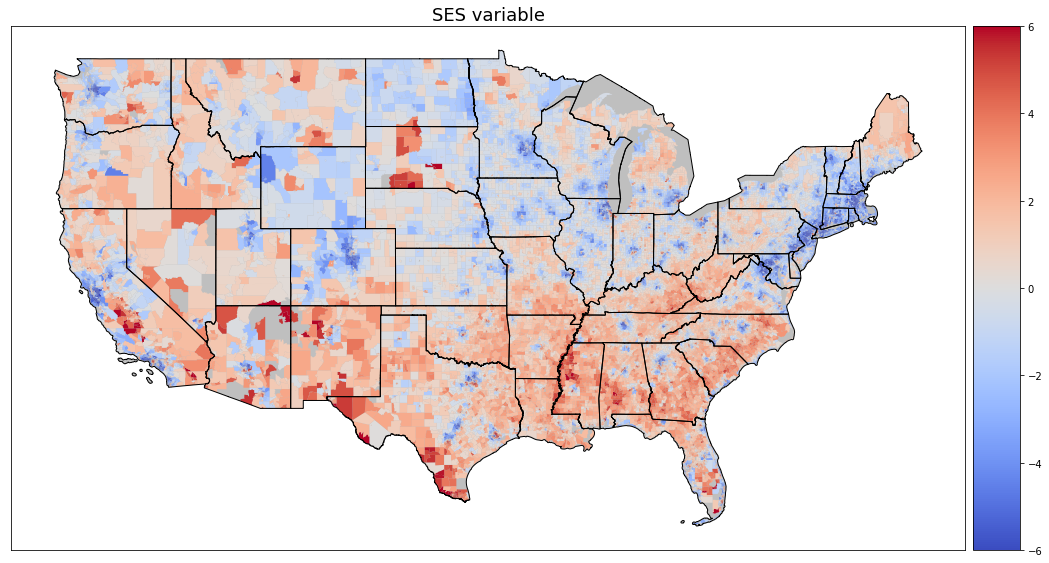

In [216]:
fig, ax = plt.subplots(1,1,figsize=(15,17 * 3.5/7.5))

state_shapes.plot(color = 'gray', alpha=0.5, ax=ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

df_temp.plot(column='SES_inv',
             cmap='coolwarm',
             legend=True,
                vmin = -6,
                vmax = 6,
                ax=ax,
                cax=cax)


state_shapes.boundary.plot(color='k', ax=ax, linewidth= 1)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
    
ax.set_title('SES variable', fontsize=18)
    
#cax.tick_params(labelsize=11)
#cax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35])
#cax.set_yticklabels(['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%'])


plt.tight_layout()
plt.savefig('temp.jpg', dpi=200)
